# Assignment 2: Prediction of Protein Expression

In [1]:
import pandas as pd
from skimage.color import rgb2hed
import skimage
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
from tempfile import TemporaryDirectory
import logging

cudnn.benchmark = True

In [2]:
logging.basicConfig(
    filename='info.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [4]:
# Set the image folder path
image_folder = 'patches_256/'
resized_folder = 'patches_64/'
gray_folder = 'patches_gray/'

training_specimen_id = ['A1', 'B1', 'D1']

In [4]:
df = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')

df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']

## Question No. 1: Data Analysis

***Using training data**, answer the following questions:*

***i. Counting Examples:** Determine the number of "examples" or spots present in each specimen.*

In [5]:
# Count the number of examples (spots) in each specimen
examples_count = df['specimen_id'].value_counts()

# Print the results
print("Number of examples in each specimen:")
print(examples_count)

Number of examples in each specimen:
specimen_id
C1    4129
A1    2894
D1    1753
B1    1145
Name: count, dtype: int64


***ii. Protein Expression Histograms:** For each specimen, generate histograms to visualize the expression values of 'NESTIN', 'cMYC', and 'MET' and discuss your observations.*

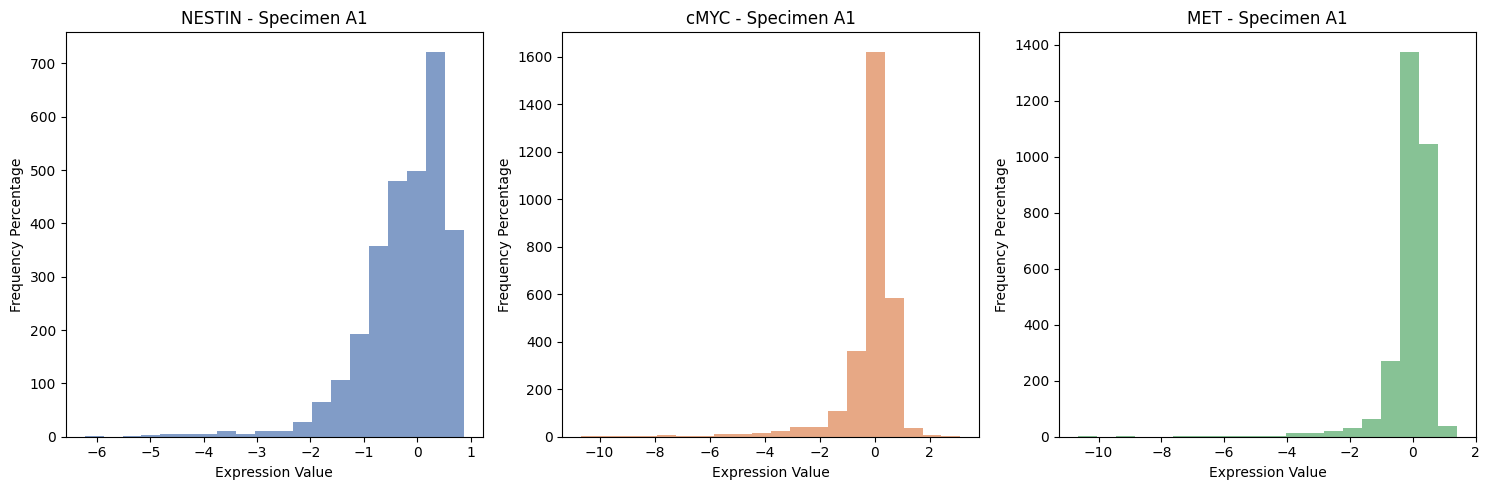

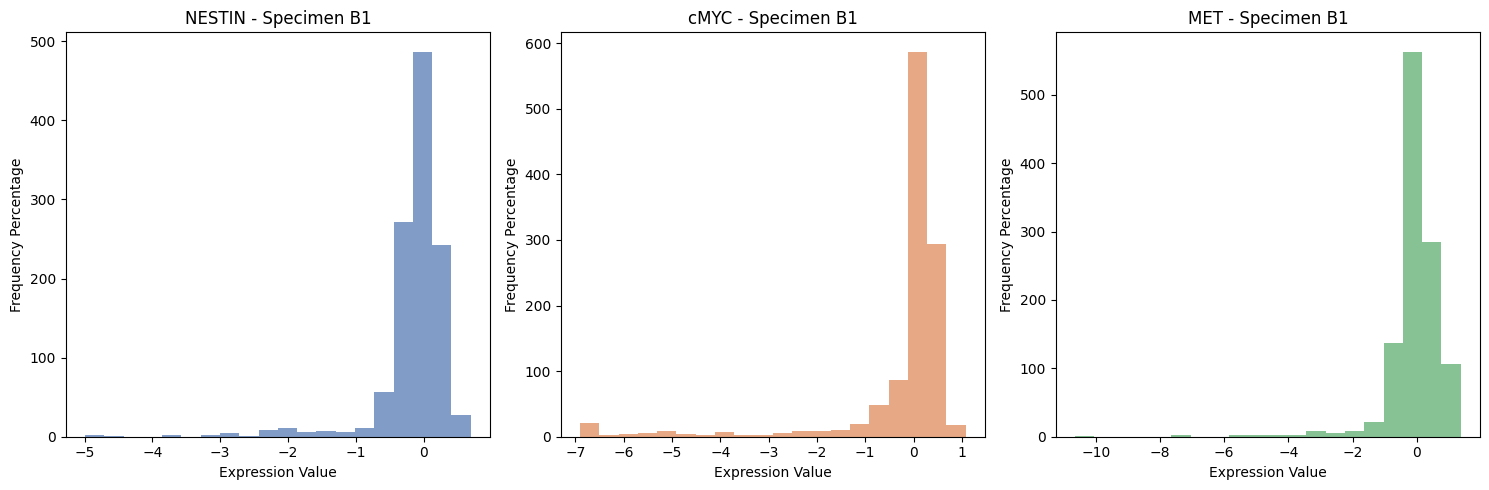

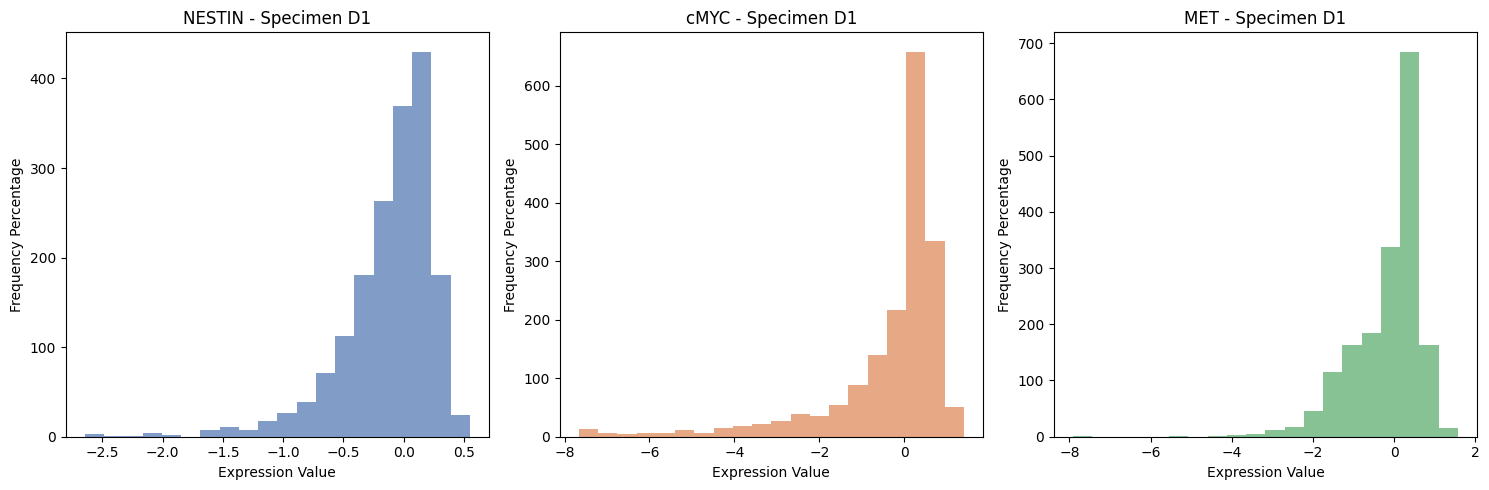

In [6]:
# List of proteins to visualize
proteins_to_visualize = ['NESTIN', 'cMYC', 'MET']

# Set the color palette for better visualization
colors = sns.color_palette("deep")

# Loop through each specimen and generate subplots
for i, specimen_id in enumerate(training_specimen_id):
    # Select data for the current specimen
    specimen_data = df[df['specimen_id'] == specimen_id]
    
    # Create a subplot for each protein
    plt.figure(figsize=(15, 5))
    for j, protein in enumerate(proteins_to_visualize):
        plt.subplot(1, 3, j + 1)
        plt.hist(specimen_data[protein], bins=20, color=colors[j], alpha=0.7)
        plt.title(f'{protein} - Specimen {specimen_id}')
        plt.xlabel('Expression Value')
        plt.ylabel('Frequency Percentage')
    
    plt.tight_layout()
    plt.show()

The protein expression histograms for 'NESTIN,' 'cMYC,' and 'MET' all indicate negatively skewed distributions centered around zero. However, each specimen exhibits distinct variations in protein expression with slighly different histograms for the same protein. This suggest specimen-specific protein expression and different characteristics of each biological sample. From the expression levels of these three proteins, B1 and D1 appear to be more similar to each other than A1.

***iii. Image Pre-processing:** Convert a selection of images from RGB to HED color space, focusing on the Hematoxylin channel (H) to highlight cellular nuclei. Provide visual examples and follow the hints in the provided notebook.*

Showing image patches_256/A1_39x97.png from specimen A1


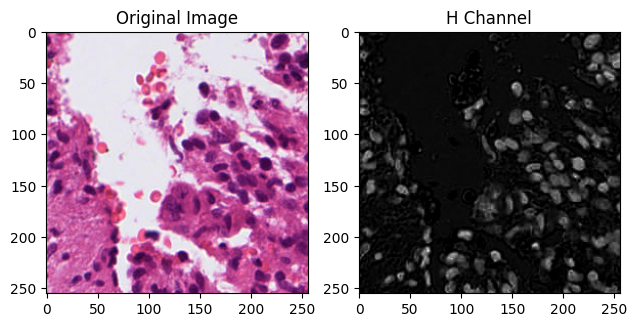

Showing image patches_256/B1_11x75.png from specimen B1


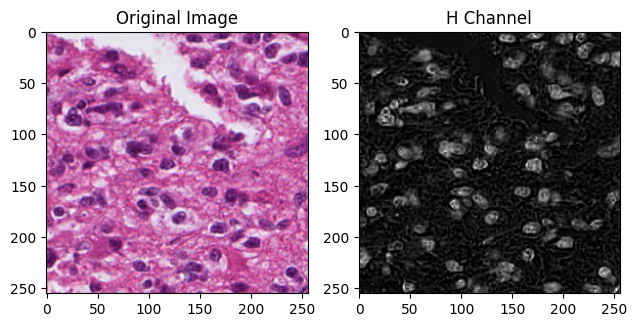

Showing image patches_256/D1_27x89.png from specimen D1


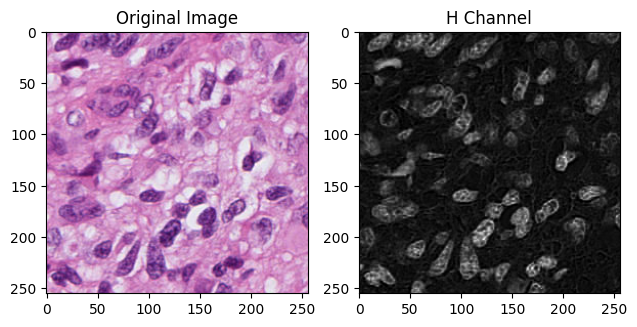

In [33]:
# Function to convert RGB to HED and display the Hematoxylin channel
def convert_and_display_hematoxylin(image_path):
    # Read the RGB image
    rgb_image = imread(image_path)[:, :, :3]
    
    # Convert RGB to HED
    hed_image = rgb2hed(rgb_image)
    
    # Extract the Hematoxylin channel (H)
    hematoxylin_channel = hed_image[:, :, 0]
    
    # Display the original and Hematoxylin channel images
    plt.figure();plt.subplot(1, 2, 1);plt.imshow(rgb_image);plt.title('Original Image')
    plt.subplot(1, 2, 2);plt.imshow(hematoxylin_channel, cmap='gray');plt.title('H Channel')
    plt.tight_layout();plt.show()

# Function to randomly select and display an image from each specimen
def display_random_images(image_folder, specimen_ids):
    # Loop through each specimen
    for i, specimen_id in enumerate(specimen_ids):
        # Get a list of image paths for the current specimen
        specimen_image_paths = [os.path.join(image_folder, file) \
            for file in os.listdir(image_folder) if file.startswith(specimen_id)]
        
        # Randomly select an image path
        random_image_path = random.choice(specimen_image_paths)
        print("Showing image", random_image_path, "from specimen", specimen_id)
        
        # Read and display the randomly selected image
        convert_and_display_hematoxylin(random_image_path)

# Display random images from each specimen
display_random_images(image_folder, training_specimen_id)

***iv. H-channel Analysis:** Calculate the average intensity of the H-channel for each image. Create a scatter plot comparing these averages against the expression levels of NESTIN for each image. Assess the correlation between H-channel intensity and NESTIN expression. Discuss the potential of H-channel average as a predictive feature for NESTIN expression.*

In [7]:
# Calculate the average intensity of the H-channel for each image
df['H_channel_avg'] = df.index.map(lambda image_id: np.mean(
    rgb2hed(imread(os.path.join(image_folder, f'{image_id}.png'))[:, :, :3])[:, :, 0]
))

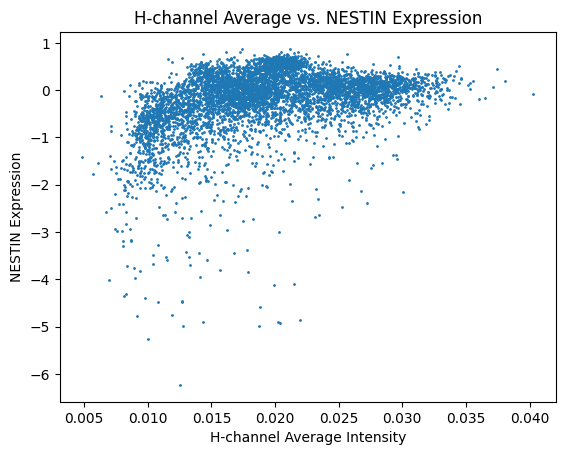

In [36]:
# Scatter plot comparing H-channel averages against NESTIN expression
plt.figure()
plt.scatter(data=df[df['specimen_id'].isin(training_specimen_id)], \
    x='H_channel_avg', y='NESTIN', s=1)
plt.title('H-channel Average vs. NESTIN Expression')
plt.xlabel('H-channel Average Intensity')
plt.ylabel('NESTIN Expression')
plt.show()

In [37]:
h_channel_intensity = df['H_channel_avg']
nestin_expression = df['NESTIN']

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(h_channel_intensity, nestin_expression)[0, 1]

print(f"Pearson Correlation Coefficient: {correlation}")

Pearson Correlation Coefficient: 0.37038527394872667


In [42]:
df.to_csv('protein_expression.csv')

In [2]:
df = pd.read_csv('protein_expression.csv')
df = df.set_index('image_id')

A Pearson correlation coefficient of approximately 0.37 suggests a moderate positive correlation between the H-channel intensity and NESTIN expression. As the H-channel intensity increases, there is a tendency for NESTIN expression to also increase. The H-channel average may have some predictive power for NESTIN expression. However, the correlation is not extremely strong. Further investigations, such as regression modeling, exploring the inclusion of other relevant features with different regression models, could help quantify and understand the predictive capacity of the H-channel average.

***v. Performance Metrics for Prediction:** Discuss suitable performance metrics for predicting protein expression from images. Identify the most appropriate metric for this specific problem and justify your choice.*

Here are some relevant performance metrics for regression problems:

1. **Mean Squared Error (MSE)**: MSE is a common regression metric that measures the average squared difference between predicted and actual values. It penalizes larger errors more heavily. However, it might be sensitive to outliers.

2. **Root Mean Squared Error (RMSE)**: RMSE is the square root of the MSE and provides a more interpretable measure in the same units as the target variable. Like MSE, it is sensitive to outliers.

3. **Mean Absolute Error (MAE)**: MAE measures the average absolute difference between predicted and actual values. It is less sensitive to outliers compared to MSE and RMSE.

4. **R-squared (R2)**: R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, with higher values indicating a better fit.

5. **Explained Variance Score**: Similar to R2, indicates the proportion of variance explained by the model.

6. **Pearson Correlation Coefficient**: Quantifies the linear relationship between two variables.

I consider using R2 Score for the following reasons:

1. **Strong Interpretability:** R² provides a measure of the model's ability to explain the variance of the target variable. We are concerned about the model's capacity to explain variation in protein expression, so R² is an intuitive metric.

2. **Applicability to Regression Problems:** R² is a commonly used performance metric in regression problems for predicting continuous variables. It is a classic and widely accepted metric, making it convenient for comparisons with other studies.

3. **Intuitive Understanding:** With R² we can compare the model to a baseline that simply predicts the mean. An R² close to 1 signifies that the model fits the data well, while an R² close to 0 indicates poor model performance.

## Question No. 2: Feature Extraction and Classical Regression

***For the following questions, use the expression of NESTIN as the output prediction target variable.***

*i. Extract features from an image, focusing on the following aspects:*

*1. Calculate the average and variance for each of the 'H' (from HED), red, green, and blue channels.*

In [5]:
# Split the DataFrame into train/validation and test
df_train = df[df['specimen_id'].isin(training_specimen_id)]
df_test = df[~df['specimen_id'].isin(training_specimen_id)]

# Print the size of the split DataFrames
print("Training DataFrame Size:", df_train.shape[0])
print("Testing DataFrame Size:", df_test.shape[0])

Training DataFrame Size: 5792
Testing DataFrame Size: 4129


In [16]:
# Initialize a new dataframe df_hrgb with the same index as df
df_hrgb = pd.DataFrame(index=df.index)

# Calculate the average and variance for each channel and add to df_hrgb
channels = ['Red', 'Green', 'Blue']

for image_id in df.index:
    # Read the RGB image
    rgb_image = imread(os.path.join(image_folder, f'{image_id}.png'))[:, :, :3]
    
    for i, channel in enumerate(channels):
        # Calculate average and variance for the channels
        channel_data = rgb_image[:, :, i]
        df_hrgb.loc[image_id, f'{channel}_avg'] = np.mean(channel_data)
        df_hrgb.loc[image_id, f'{channel}_var'] = np.var(channel_data)
    
    # Convert RGB to HED
    hed_image = rgb2hed(rgb_image)
    hematoxylin_channel = hed_image[:, :, 0]
    df_hrgb.loc[image_id, 'H_avg'] = np.mean(hematoxylin_channel)
    df_hrgb.loc[image_id, 'H_var'] = np.var(hematoxylin_channel)

In [44]:
df_hrgb.to_csv('patches_hrgb.csv')

In [6]:
df_hrgb = pd.read_csv('patches_hrgb.csv')
df_hrgb = df_hrgb.set_index('image_id')

*2. Additionally, consider other potentially useful features for this task and justify their inclusion. For example:*

- *PCA (Principal Component Analysis): Applying PCA, such as randomized PCA or incremental PCA, can significantly reduce dimensionality while preserving the variance in the image data, making it easier to identify patterns. This is particularly useful for large datasets or high-resolution images where computational efficiency is a concern. Refer to sklearn.decomposition.PCA for implementation details. You might choose to reduce the dataset size or image dimensions for PCA to manage complexity.*

We resize the images to 64 * 64 to keep them within the memory limit when applying PCA.

In [48]:
# Create the resized folder if it doesn't exist
os.makedirs(resized_folder, exist_ok=True)

# Get the list of file names in the original folder
file_names = os.listdir(image_folder)

# Iterate through each file and resize
for file_name in file_names:
    # Load the original image
    original_image = Image.open(os.path.join(image_folder, file_name))
    
    # Resize the image to 64x64
    resized_image = original_image.resize((64, 64))
    
    # Save the resized image with the same file name in the resized folder
    resized_image.save(os.path.join(resized_folder, file_name))

In [182]:
# Create a list to store the image data
image_data = []

# Iterate through the index of df_train
for index in df_train.index:
    # Load the resized image
    image_path = os.path.join(resized_folder, f"{index}.png")
    image = np.array(imread(image_path)[:, :, :3])
    
    # Flatten the 64x64 image to a 1D array
    flattened_image = image.flatten()
    
    # Append the flattened image to the list
    image_data.append(flattened_image)

# Convert the list to a NumPy array
image_data_array = np.array(image_data)

In [61]:
# Perform randomized PCA
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(image_data_array)

PCA(random_state=42, svd_solver='randomized')

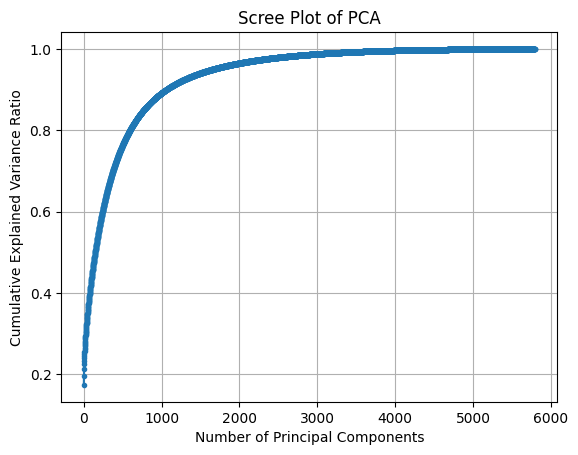

Number of dimensions for 95% variance: 1659


In [64]:
# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the scree graph
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='.')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot of PCA')
plt.grid(True)
plt.show()

# Find the number of dimensions that explain 95% variance
num_dimensions_95_percent_variance = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f'Number of dimensions for 95% variance: {num_dimensions_95_percent_variance}')

In [186]:
# Perform randomized PCA to reduce dimensionality to 2000
pca = PCA(n_components=2000, svd_solver='randomized', random_state=42)
pca.fit(image_data_array) # fitting on training data only

PCA(n_components=2000, random_state=42, svd_solver='randomized')

In [187]:
# Create a list to store the image data
image_data = []

# Iterate through the index of df
for index in df.index:
    # Load the resized image
    image_path = os.path.join(resized_folder, f"{index}.png")
    image = np.array(imread(image_path)[:, :, :3])
    
    # Flatten the 64x64 image to a 1D array
    flattened_image = image.flatten()
    
    # Append the flattened image to the list
    image_data.append(flattened_image)

# Convert the list to a NumPy array
image_data_array = np.array(image_data)

In [188]:
pca_result = pca.transform(image_data_array) # transforming training and test data

# Create a DataFrame with the PCA results and original indices
df_pca = pd.DataFrame(data=pca_result, index=df.index)

In [189]:
df_pca.to_csv('patches_pca.csv')

In [7]:
df_pca = pd.read_csv('patches_pca.csv')
df_pca = df_pca.set_index('image_id')

- *GLCM (Gray Level Co-occurrence Matrix): GLCM features can provide insights into the texture of the image, capturing aspects like contrast, correlation, and homogeneity, which might be relevant for distinguishing between different image types. See scikit-image GLCM features for more information.*

In [76]:
# Create the gray folder if it doesn't exist
os.makedirs(gray_folder, exist_ok=True)

# Get the list of file names in the original folder
file_names = os.listdir(image_folder)

# Iterate through each file and resize
for file_name in file_names:
    # Load the original image
    original_image = imread(os.path.join(image_folder, file_name))[:, :, :3]
    
    # Turn the image into gray
    gray_image = rgb2gray(original_image)
    
    # Save the gray image with the same file name in the gray folder
    Image.fromarray((gray_image * 255).astype(np.uint8)).save(os.path.join(gray_folder, file_name))

In [15]:
# Create a list to store the image data
image_data_gray = []

# Iterate through the index of df
for index in df.index:
    # Load the gray image
    image_path = os.path.join(gray_folder, f"{index}.png")
    image = np.array(imread(image_path))
    
    # Append the gray image to the list
    image_data_gray.append(image)

# Convert the list to a NumPy array
image_data_gray_array = np.array(image_data_gray)

In [16]:
# Define GLCM properties to calculate
glcm_properties = ['contrast', 'correlation', 'homogeneity', 'ASM']

# Initialize an empty DataFrame df_glcm
df_glcm = pd.DataFrame(index=df.index, columns=glcm_properties)

# Calculate GLCM features for each image
for image_index, image_data in zip(df.index, image_data_gray_array):
    # Compute GLCM
    glcm = graycomatrix(image_data.astype('uint8'), distances=[1], angles=[0], symmetric=True, normed=True)
    
    # Calculate GLCM properties
    properties = [graycoprops(glcm, prop)[0, 0] for prop in glcm_properties]
    
    # Assign values to the DataFrame
    df_glcm.loc[image_index, glcm_properties] = properties

In [17]:
df_glcm.to_csv('patches_glcm.csv')

In [8]:
df_glcm = pd.read_csv('patches_glcm.csv')
df_glcm = df_glcm.set_index('image_id')

- *Transfer Learning Features: Utilizing a pre-trained neural network to extract feature embeddings can leverage learned patterns from vast datasets, potentially improving your model's ability to generalize from the visual content of the images.*

We use a VGG16 model without its top layers to extract feature embeddings.

In [20]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [21]:
# Create a list to store the image data
image_data = []

# Iterate through the index of df
for index in df.index:
    # Load the image
    image_path = os.path.join(image_folder, f"{index}.png")
    image = np.array(imread(image_path)[:, :, :3])
    
    # Append the image to the list
    image_data.append(image)

# Convert the list to a NumPy array
image_data_array = np.array(image_data)

In [22]:
transfer_features = model.predict(image_data_array)

311/311 [==============================] - 5897s 19s/step


In [28]:
flattened_transfer_features = transfer_features.reshape(9921, -1)
df_transfer = pd.DataFrame(data=flattened_transfer_features, index=df.index)

In [30]:
df_transfer.to_csv('patches_transfer.csv')

In [ ]:
df_transfer = pd.read_csv('patches_transfer.csv')
df_transfer = df_transfer.set_index('image_id')

*Feature Evaluation:*

- *After feature extraction, plot scatter plots and calculate the correlation coefficient for each feature (from steps a-c) versus the target variable. This analysis will help identify which features are most predictive of the target.*
- *Important Features: Discuss the importance of selected features based on their correlation with the target variable and their contribution to model performance.*

*Note: Ensure that PCA and any model fitting only use training data to avoid information leakage. You can also consider resizing images, selecting specific image regions or reducing the number of training images to manage computational load.*

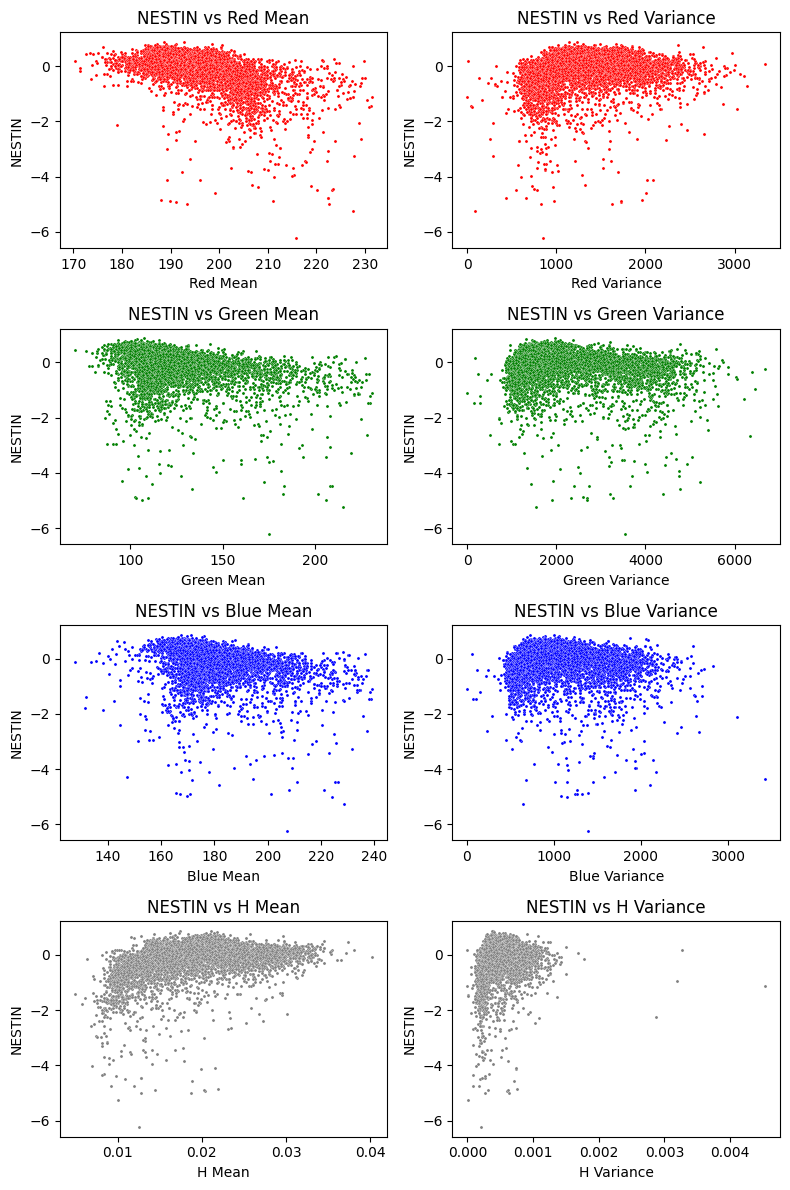

Feature   Mean CC  Variance CC
0     Red -0.544325     0.178112
1   Green -0.294141    -0.147167
2    Blue -0.236451    -0.114420
3       H  0.379616     0.164741

In [29]:
# Concatenate df_train['NESTIN'] column with df_hrgb
merged_df = pd.concat([df_train['NESTIN'], df_hrgb.loc[df_train.index]], axis=1)

features = ['Red', 'Green', 'Blue', 'H']
colours = ['red', 'green', 'blue', 'grey']

# Create subplots with two columns per row
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(8, 3 * len(features)))

# Create a list to store correlation coefficients
correlation_coefficients = []

# Iterate over features
for i, feature in enumerate(features):
    # Scatter plot for each feature against NESTIN
    sns.scatterplot(x=feature+'_avg', y='NESTIN', data=merged_df, ax=axes[i, 0], s=5, color=colours[i])
    axes[i, 0].set_title(f'NESTIN vs {feature} Mean')
    axes[i, 0].set_xlabel(f'{feature} Mean')
    axes[i, 0].set_ylabel('NESTIN')

    sns.scatterplot(x=feature+'_var', y='NESTIN', data=merged_df, ax=axes[i, 1], s=5, color=colours[i])
    axes[i, 1].set_title(f'NESTIN vs {feature} Variance')
    axes[i, 1].set_xlabel(f'{feature} Variance')
    axes[i, 1].set_ylabel('NESTIN')

    # Calculate and store the correlation coefficient
    correlation_coefficient_mean = merged_df[feature+'_avg'].corr(merged_df['NESTIN'])
    correlation_coefficient_var = merged_df[feature+'_var'].corr(merged_df['NESTIN'])
    correlation_coefficients.append((feature, correlation_coefficient_mean, correlation_coefficient_var))

# Adjust layout
plt.tight_layout()
plt.show()

# Display the correlation coefficients in a table
correlation_df = pd.DataFrame(correlation_coefficients, \
    columns=['Feature', 'Mean CC', 'Variance CC'])
correlation_df

It can be observed that the average of 'H' (from HED), red, green, or blue channels provides more information for predicting the target variable compared to the variance. Particularly, 'H' and Red channels are more informative than the other two.

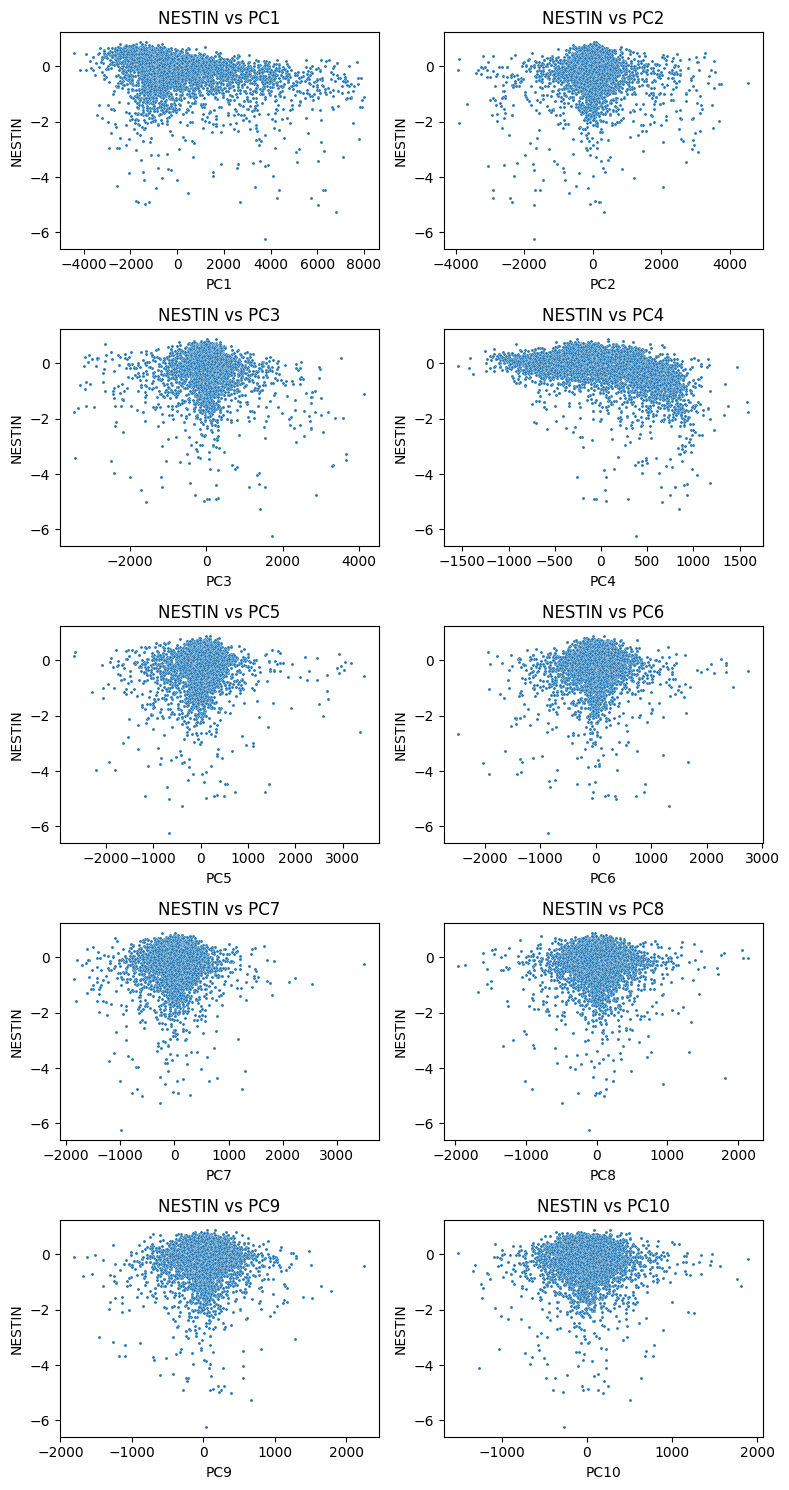

Feature        CC
0     PC1 -0.301282
1     PC2  0.018984
2     PC3 -0.077291
3     PC4 -0.443014
4     PC5  0.099556
5     PC6  0.079451
6     PC7  0.026465
7     PC8 -0.019523
8     PC9  0.026785
9    PC10  0.001022

In [190]:
# Select the top ten principal components
top_pca_columns = range(10)

# Create a DataFrame with the selected principal components and 'NESTIN'
merged_df_pca = pd.concat([df_train['NESTIN'], df_pca.loc[df_train.index][top_pca_columns]], axis=1)

# Create subplots with two columns per row
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 15))

# Create a list to store correlation coefficients
correlation_coefficients = []

# Iterate over features
for i in top_pca_columns:
    # Scatter plot for each feature against NESTIN
    feature = 'PC' + str(i+1)
    sns.scatterplot(x=i, y='NESTIN', data=merged_df_pca, ax=axes[i//2, i%2], s=5)
    axes[i//2, i%2].set_title(f'NESTIN vs {feature}')
    axes[i//2, i%2].set_xlabel(f'{feature}')
    axes[i//2, i%2].set_ylabel('NESTIN')

    # Calculate and store the correlation coefficient
    correlation_coefficient = merged_df_pca[i].corr(merged_df_pca['NESTIN'])
    correlation_coefficients.append((feature, correlation_coefficient))

# Adjust layout
plt.tight_layout()
plt.show()

# Display the correlation coefficients in a table
correlation_df = pd.DataFrame(correlation_coefficients, columns=['Feature', 'CC'])
correlation_df

In [191]:
# All 2000 principal components
pca_columns = range(2000)

# Create a DataFrame with the selected principal components and 'NESTIN'
merged_df_pca_full = pd.concat([df_train['NESTIN'], df_pca.loc[df_train.index]], axis=1)

# Calculate correlation coefficients
correlation_coefficients = {}
for column in pca_columns:
    correlation_coefficient = merged_df_pca_full[column].corr(merged_df_pca_full['NESTIN'])
    correlation_coefficients['PC' + str(column+1)] = correlation_coefficient

# Sort correlation coefficients in descending order
sorted_correlations = sorted(correlation_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_correlation_df = pd.DataFrame(sorted_correlations, columns=['Feature', 'CC'])
sorted_correlation_df[abs(sorted_correlation_df['CC']) > 0.1]

Feature        CC
0     PC4 -0.443014
1     PC1 -0.301282

Among all the 2000 principal components obtained from PCA dimensionality reduction, only PC4 and PC1 exhibit a remarkably high correlation with the target variable, while the others are not as significant in terms of predictive power.

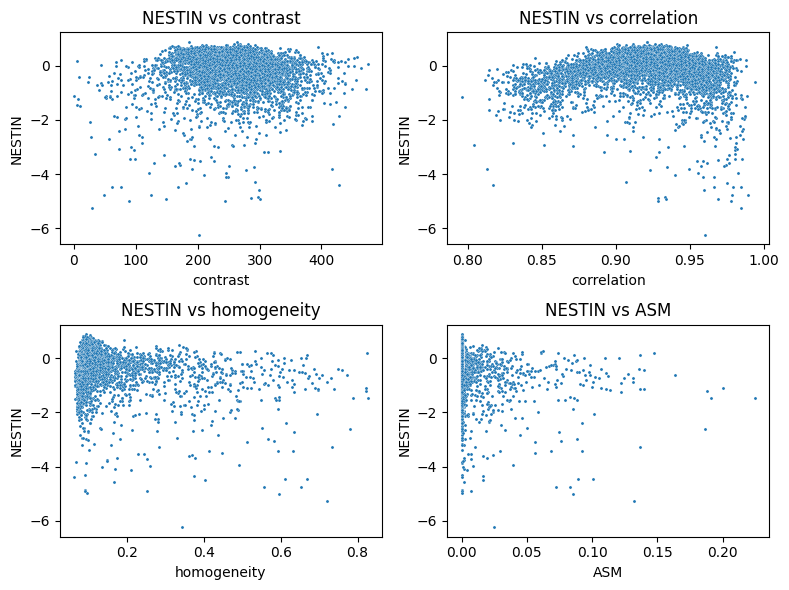

Feature        CC
0     contrast -0.015098
1  correlation  0.060973
2  homogeneity -0.317877
3          ASM -0.266813

In [18]:
# Concatenate df_train['NESTIN'] column with df_glcm
merged_df = pd.concat([df_train['NESTIN'], df_glcm.loc[df_train.index]], axis=1)

# Create subplots with two columns per row
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

# Create a list to store correlation coefficients
correlation_coefficients = []

# Iterate over features
for i, feature in enumerate(glcm_properties):
    # Scatter plot for each feature against NESTIN
    sns.scatterplot(x=feature, y='NESTIN', data=merged_df, ax=axes[i//2, i%2], s=5)
    axes[i//2, i%2].set_title(f'NESTIN vs {feature}')
    axes[i//2, i%2].set_xlabel(f'{feature}')
    axes[i//2, i%2].set_ylabel('NESTIN')

    # Calculate and store the correlation coefficient
    correlation_coefficient = merged_df[feature].corr(merged_df['NESTIN'])
    correlation_coefficients.append((feature, correlation_coefficient))

# Adjust layout
plt.tight_layout()
plt.show()

# Display the correlation coefficients in a table
correlation_df = pd.DataFrame(correlation_coefficients, columns=['Feature', 'CC'])
correlation_df

Among the GLCM features, homogeneity and ASM are more predictive of the target.

In [104]:
# All 32768 transfered features
transfer_columns = range(df_transfer.shape[1])

# Create a DataFrame with the features and 'NESTIN'
merged_df_transfer = pd.concat([df_train['NESTIN'], df_transfer.loc[df_train.index]], axis=1)

# Calculate correlation coefficients
correlation_coefficients = {}
for column in transfer_columns:
    if (merged_df_transfer[column] == 0).all():
        correlation_coefficients['Feature ' + str(column+1)] = 0
    else:
        correlation_coefficient = merged_df_transfer[column].corr(merged_df_transfer['NESTIN'])
        correlation_coefficients['Feature ' + str(column+1)] = correlation_coefficient

# Sort correlation coefficients in descending order
sorted_correlations = sorted(correlation_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_correlation_df = pd.DataFrame(sorted_correlations, columns=['Feature', 'CC'])

In [105]:
greater_than_01 = sorted_correlation_df[abs(sorted_correlation_df['CC']) > 0.1]
greater_than_01

Feature        CC
0       Feature 858  0.250821
1     Feature 29530  0.250586
2     Feature 32090  0.246884
3      Feature 1370  0.242957
4     Feature 32602  0.241663
...             ...       ...
2266  Feature 26251 -0.100114
2267  Feature 30961 -0.100103
2268  Feature 15208  0.100088
2269  Feature 27689 -0.100045
2270  Feature 17127 -0.100037

[2271 rows x 2 columns]

In [108]:
greater_than_02 = sorted_correlation_df[abs(sorted_correlation_df['CC']) > 0.2]
greater_than_02

Feature        CC
0      Feature 858  0.250821
1    Feature 29530  0.250586
2    Feature 32090  0.246884
3     Feature 1370  0.242957
4    Feature 32602  0.241663
..             ...       ...
128  Feature 15867 -0.200470
129  Feature 26223 -0.200452
130  Feature 29128  0.200329
131  Feature 12760  0.200266
132  Feature 13492 -0.200226

[133 rows x 2 columns]

Among the feature embeddings extracted using VGG16, the contributions of each feature to prediction are more dispersed.

*ii. Apply the following regression models using the features from Q2(i):*

*For each model, create scatter plots to compare the true and predicted values on the test data. Additionally, evaluate and report your models' performance using the following metrics: RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient, and R2 score. Reference for metrics: sklearn.metrics.*

*You may choose either sklearn or PyTorch for implementation. It's your responsibility to select appropriate hyperparameters, such as the kernel and its parameters for SVR, or the architecture specifics for the MLP.*

*Deliverables:*

*- Scatter plots for true vs. predicted values for each model type.*

*- Performance metrics (RMSE, Pearson, Spearman, R2 score) on the test data.*

- ***Ordinary Least Squares (OLS) Regression***

We filter out the features whose coefficients with the target has an absolute value greater than 0.1/0.2 and merge the features from HRGB, PCA, and GLCM (separately and combined). The features acquired with transfer learning are treated separately.

In [9]:
df_hrgb_features_train = pd.concat([
    df_hrgb.loc[df_train.index],
    df_train['NESTIN']
], axis=1)

df_hrgb_features_train.columns = df_hrgb_features_train.columns.astype(str)

df_hrgb_features_test = pd.concat([
    df_hrgb.loc[df_test.index],
    df_test['NESTIN']
], axis=1)

df_hrgb_features_test.columns = df_hrgb_features_test.columns.astype(str)

In [11]:
pca_columns = ['0', '3']

df_pca_features_train = pd.concat([
    df_pca.loc[df_train.index][pca_columns],
    df_train['NESTIN']
], axis=1)

df_pca_features_train.columns = df_pca_features_train.columns.astype(str)

df_pca_features_test = pd.concat([
    df_pca.loc[df_test.index][pca_columns],
    df_test['NESTIN']
], axis=1)

df_pca_features_test.columns = df_pca_features_test.columns.astype(str)

In [12]:
glcm_columns = ['homogeneity', 'ASM']

df_glcm_features_train = pd.concat([
    df_glcm.loc[df_train.index][glcm_columns],
    df_train['NESTIN']
], axis=1)

df_glcm_features_train.columns = df_glcm_features_train.columns.astype(str)

df_glcm_features_test = pd.concat([
    df_glcm.loc[df_test.index][glcm_columns],
    df_test['NESTIN']
], axis=1)

df_glcm_features_test.columns = df_glcm_features_test.columns.astype(str)

In [422]:
df_combine_features_train = pd.concat([
    df_hrgb.loc[df_train.index],
    df_pca.loc[df_train.index][pca_columns],
    df_glcm.loc[df_train.index][glcm_columns],
    df_train['NESTIN']
], axis=1)

df_combine_features_train.columns = df_combine_features_train.columns.astype(str)

df_combine_features_test = pd.concat([
    df_hrgb.loc[df_test.index],
    df_pca.loc[df_test.index][pca_columns],
    df_glcm.loc[df_test.index][glcm_columns],
    df_test['NESTIN']
], axis=1)

df_combine_features_test.columns = df_combine_features_test.columns.astype(str)

In [204]:
# Filter out indices from greater_than_02['Feature']
feature_indices = [int(feature.split()[-1])-1 for feature in greater_than_02['Feature']]

df_transfer_features_train = pd.concat([
    df_transfer.loc[df_train.index][feature_indices],
    df_train['NESTIN']
], axis=1)

df_transfer_features_train.columns = df_transfer_features_train.columns.astype(str)

df_transfer_features_test = pd.concat([
    df_transfer.loc[df_test.index][feature_indices],
    df_test['NESTIN']
], axis=1)

df_transfer_features_test.columns = df_transfer_features_test.columns.astype(str)

In [13]:
def evaluation(y_test, y_pred, model_name, features_name):
    # Calculate RMSE (Root Mean Squared Error)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    # Calculate Pearson Correlation Coefficient
    pearson_corr, _ = pearsonr(y_test, y_pred)
    # Calculate Spearman Correlation Coefficient
    spearman_corr, _ = spearmanr(y_test, y_pred)
    # Calculate R2 Score
    r2 = r2_score(y_test, y_pred)

    # Print evaluation metrics for OLS Regression Model
    print(f'Evaluation metrics for {model_name} on {features_name}:')
    print(f'RMSE (Root Mean Square Error): {rmse:.4f}')
    print(f'Pearson Correlation Coefficient: {pearson_corr:.4f}')
    print(f'Spearman Correlation Coefficient: {spearman_corr:.4f}')
    print(f'R2 Score: {r2:.4f}')

    plt.figure()
    sns.scatterplot(x=y_test, y=y_pred, s=5)
    plt.title(f'{model_name} on {features_name}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

def ols_regression(df_train, df_test, df_name):
    # Split the data into training and validation
    X_train, y_train = df_train.drop('NESTIN', axis=1), df_train['NESTIN']
    X_test, y_test = df_test.drop('NESTIN', axis=1), df_test['NESTIN']

    # OLS Regression Model
    ols_model = LinearRegression()
    ols_model.fit(X_train, y_train)

    # Predict the target variable on the test set
    y_pred_ols = ols_model.predict(X_test)
    evaluation(y_test, y_pred_ols, 'OLS Regression', df_name)

Evaluation metrics for OLS Regression on HRGB:
RMSE (Root Mean Square Error): 0.6531
Pearson Correlation Coefficient: 0.5735
Spearman Correlation Coefficient: 0.6839
R2 Score: 0.0261


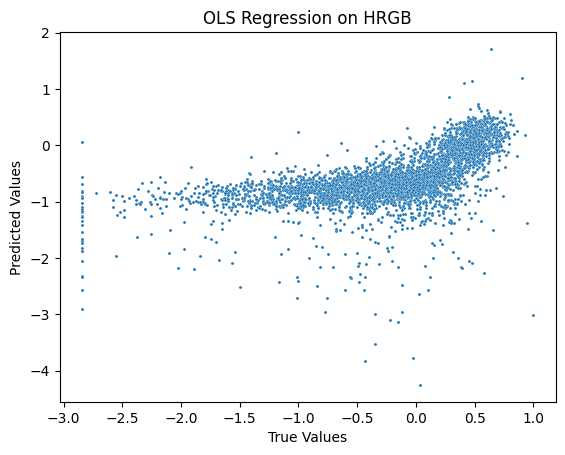

In [279]:
ols_regression(df_hrgb_features_train, df_hrgb_features_test, 'HRGB')

Evaluation metrics for OLS Regression on PCA:
RMSE (Root Mean Square Error): 0.5700
Pearson Correlation Coefficient: 0.6464
Spearman Correlation Coefficient: 0.7399
R2 Score: 0.2584


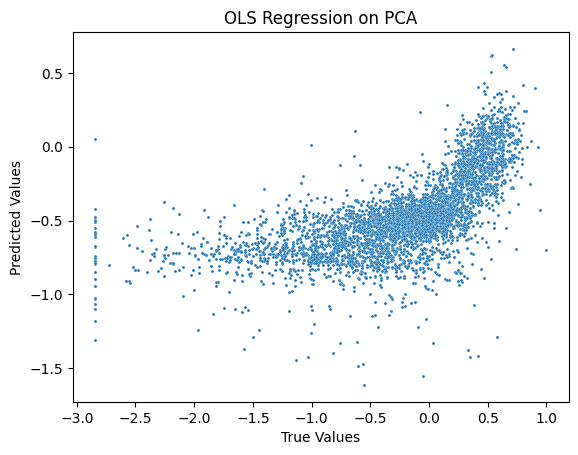

In [280]:
ols_regression(df_pca_features_train, df_pca_features_test, 'PCA')

Evaluation metrics for OLS Regression on GLCM:
RMSE (Root Mean Square Error): 0.6845
Pearson Correlation Coefficient: -0.0101
Spearman Correlation Coefficient: -0.5752
R2 Score: -0.0697


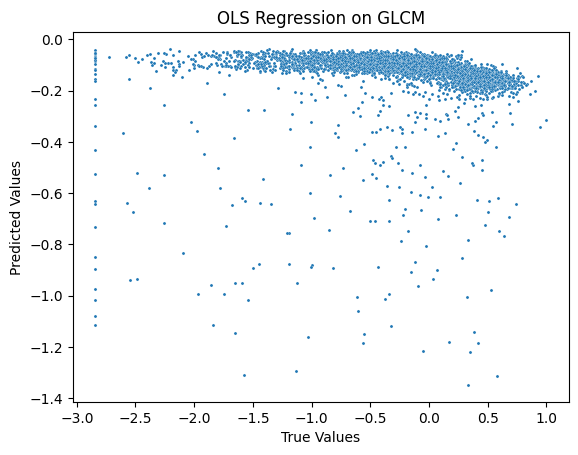

In [281]:
ols_regression(df_glcm_features_train, df_glcm_features_test, 'GLCM')

Evaluation metrics for OLS Regression on HRGB, PCA & GLCM:
RMSE (Root Mean Square Error): 0.6567
Pearson Correlation Coefficient: 0.5647
Spearman Correlation Coefficient: 0.6626
R2 Score: 0.0156


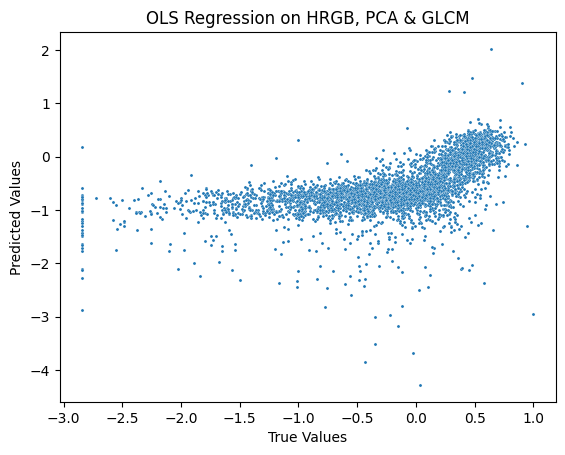

In [424]:
ols_regression(df_combine_features_train, df_combine_features_test, 'HRGB, PCA & GLCM')

Evaluation metrics for OLS Regression on Transfer Learning:
RMSE (Root Mean Square Error): 0.5943
Pearson Correlation Coefficient: 0.4715
Spearman Correlation Coefficient: 0.5657
R2 Score: 0.1937


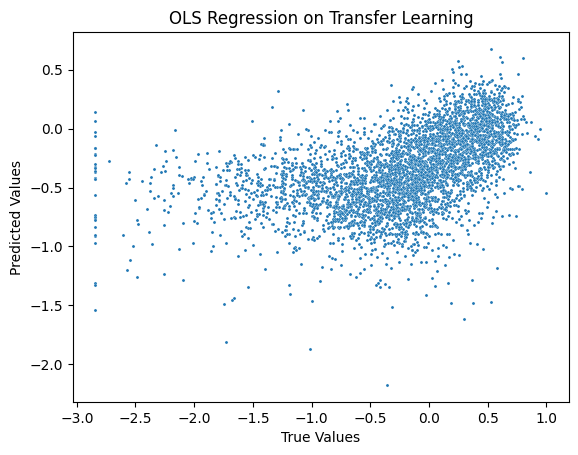

In [262]:
ols_regression(df_transfer_features_train, df_transfer_features_test, 'Transfer Learning')

It can be observed that the OLS regressor exhibits very poor generalization performance on the test set, especially when using HRGB and GLCM features, with which the R2 Score is very close to, or even smaller than 0, indicating that the model's ability to explain the variance of the target variable is approximately the same as or even worse than simply predicting the average value for every test example. PCA and transferred learning approaches are slighly better, but still not very satisfying. Besides, combining different groups of features (HRGB, PCA and GLCM) together does not improve the performance.

- ***Multi-layer Perceptron (MLP)***

For each group of features, we set the input layer size of the Multi-layer Perceptron to be number of input features + 1, the output layer size to be 1, and we stick to using one hidden layer with the size as the mean of the above two.

For cross validation within grid search, leave one specimen out cross-validation is used.

In [15]:
def grid_search(regressor, param_grid, df):
    # Initialize GridSearchCV
    features = df.drop('NESTIN', axis=1)
    target = df['NESTIN']

    # Apply leave one specimen out cross-validation
    grid_search_cv = GridSearchCV(regressor, param_grid=param_grid, \
        cv=GroupKFold(n_splits=3).split(X=features, y=target, groups=df.index.str.split('_').str[0].tolist()),
            scoring='r2', n_jobs=-1, error_score=float('-inf'))
    
    # Perform grid search on the training data
    grid_search_cv.fit(features, target)
    
    return grid_search_cv

In [16]:
def sorted_score(grid_search_cv):
    # Get the results of the grid search
    results = grid_search_cv.cv_results_

    # Create a list to store relevant information
    relevant_info = []

    # Iterate through each parameter combination
    for i in range(len(results['params'])):
        if not results['mean_test_score'][i] == float('-inf'):
            params = results['params'][i]
            mean_r2 = results['mean_test_score'][i]
            std_r2 = results['std_test_score'][i]
            relevant_info.append({**params, 'mean_r2': mean_r2, 'std_r2': std_r2})

    # Sort the relevant information by mean MAE in descending order
    relevant_info.sort(key=lambda x: x['mean_r2'], reverse=True)

    return relevant_info

In [407]:
# Define the parameter grid for MLP
param_grid_mlp = {
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.01, 0.1, 1],
    'learning_rate': ['constant', 'adaptive'],
    'hidden_layer_sizes': [(10,), (50,), (100,), (10, 10), (50, 50), (100, 100)]
}

In [408]:
# Create the MLP regressor and perform grid search
mlp_hrgb_search = grid_search(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp, df_hrgb_features_train)

c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to -inf.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python31

In [409]:
relevant_info = sorted_score(mlp_hrgb_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

activation  alpha hidden_layer_sizes learning_rate solver   mean_r2  \
0   logistic   0.10         (100, 100)      constant    sgd  0.184343   
1   logistic   1.00         (100, 100)      constant    sgd  0.181993   
2   logistic   0.01         (100, 100)      adaptive    sgd  0.172796   
3   logistic   0.01         (100, 100)      constant    sgd  0.172609   
4   logistic   0.01             (100,)      constant    sgd  0.172142   
5   logistic   0.10         (100, 100)      adaptive    sgd  0.168637   
6   logistic   1.00              (50,)      adaptive    sgd  0.159376   
7   logistic   0.01              (50,)      constant    sgd  0.148899   
8   logistic   1.00         (100, 100)      adaptive    sgd  0.148466   
9   logistic   0.01           (50, 50)      constant    sgd  0.144872   

     std_r2  
0  0.020094  
1  0.019034  
2  0.016844  
3  0.013386  
4  0.010884  
5  0.016665  
6  0.018542  
7  0.024700  
8  0.003852  
9  0.036801

In [410]:
# Create the MLP regressor and perform grid search
mlp_pca_search = grid_search(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp, df_pca_features_train)

c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
78 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to -inf.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python31

In [411]:
relevant_info = sorted_score(mlp_pca_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

activation  alpha hidden_layer_sizes learning_rate solver   mean_r2  \
0   logistic   0.01              (50,)      constant   adam  0.162767   
1   logistic   0.01              (50,)      adaptive   adam  0.162767   
2   logistic   1.00              (50,)      constant   adam  0.157235   
3   logistic   1.00              (50,)      adaptive   adam  0.157235   
4   logistic   1.00         (100, 100)      adaptive    sgd  0.149328   
5   logistic   0.01           (10, 10)      constant   adam  0.148616   
6   logistic   0.01           (10, 10)      adaptive   adam  0.148616   
7   logistic   1.00              (50,)      constant    sgd  0.146187   
8   logistic   1.00         (100, 100)      constant    sgd  0.145609   
9   logistic   1.00           (50, 50)      constant   adam  0.145263   

     std_r2  
0  0.064446  
1  0.064446  
2  0.065166  
3  0.065166  
4  0.059335  
5  0.054336  
6  0.054336  
7  0.061835  
8  0.061861  
9  0.072388

In [412]:
# Create the MLP regressor and perform grid search
mlp_glcm_search = grid_search(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp, df_glcm_features_train)

In [413]:
relevant_info = sorted_score(mlp_glcm_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

activation  alpha hidden_layer_sizes learning_rate solver   mean_r2  \
0   logistic    0.1             (100,)      constant   adam  0.101676   
1   logistic    0.1             (100,)      adaptive   adam  0.101676   
2       tanh    1.0              (10,)      adaptive    sgd  0.094528   
3       tanh    1.0              (10,)      constant    sgd  0.092895   
4       tanh    1.0              (50,)      adaptive    sgd  0.089515   
5       tanh    1.0              (50,)      constant    sgd  0.089404   
6       tanh    1.0             (100,)      constant    sgd  0.089319   
7       tanh    1.0             (100,)      adaptive    sgd  0.088590   
8       tanh    1.0         (100, 100)      constant   adam  0.082874   
9       tanh    1.0         (100, 100)      adaptive   adam  0.082874   

     std_r2  
0  0.059774  
1  0.059774  
2  0.064822  
3  0.064347  
4  0.057419  
5  0.057488  
6  0.056239  
7  0.056908  
8  0.079723  
9  0.079723

In [425]:
# Create the MLP regressor and perform grid search
mlp_combine_search = grid_search(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp, df_combine_features_train)

c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to -inf.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python31

In [426]:
relevant_info = sorted_score(mlp_combine_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

activation  alpha hidden_layer_sizes learning_rate solver   mean_r2  \
0   logistic   1.00           (10, 10)      constant   adam  0.169764   
1   logistic   1.00           (10, 10)      adaptive   adam  0.169764   
2   logistic   1.00           (10, 10)      adaptive    sgd  0.095692   
3   logistic   0.10           (50, 50)      constant    sgd  0.070224   
4   logistic   0.01           (10, 10)      constant    sgd  0.064665   
5   logistic   0.01           (10, 10)      adaptive    sgd  0.058437   
6   logistic   0.10           (50, 50)      adaptive    sgd  0.056682   
7   logistic   0.01           (50, 50)      constant    sgd  0.055882   
8   logistic   0.01           (50, 50)      adaptive    sgd  0.054646   
9   logistic   0.10           (50, 50)      constant   adam  0.040809   

     std_r2  
0  0.023963  
1  0.023963  
2  0.078915  
3  0.112142  
4  0.108662  
5  0.084067  
6  0.116556  
7  0.154468  
8  0.149322  
9  0.224706

In [414]:
# Create the MLP regressor and perform grid search
mlp_transfer_search = grid_search(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp, df_transfer_features_train)

c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
42 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to -inf.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Sleepyard\AppData\Local\Programs\Python\Python31

In [415]:
relevant_info = sorted_score(mlp_transfer_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

activation  alpha hidden_layer_sizes learning_rate solver   mean_r2  \
0       relu   0.10              (10,)      constant  lbfgs  0.025559   
1       relu   0.10              (10,)      adaptive  lbfgs  0.025559   
2       relu   0.01              (10,)      constant  lbfgs -0.008529   
3       relu   0.01              (10,)      adaptive  lbfgs -0.008529   
4   logistic   1.00           (10, 10)      constant   adam -0.045829   
5   logistic   1.00           (10, 10)      adaptive   adam -0.045829   
6   logistic   1.00           (10, 10)      adaptive    sgd -0.055048   
7   logistic   1.00           (10, 10)      constant    sgd -0.057307   
8       tanh   0.01           (10, 10)      constant    sgd -0.114713   
9       tanh   0.01           (10, 10)      adaptive    sgd -0.116105   

     std_r2  
0  0.255338  
1  0.255338  
2  0.362768  
3  0.362768  
4  0.310223  
5  0.310223  
6  0.246969  
7  0.242095  
8  0.261528  
9  0.267234

In [386]:
def mlp_regression(df_train, df_test, df_name, model):
    # Split the data into training and validation
    X_train, y_train = df_train.drop('NESTIN', axis=1), df_train['NESTIN']
    X_test, y_test = df_test.drop('NESTIN', axis=1), df_test['NESTIN']

    # MLP Regression Model
    model.fit(X_train, y_train)

    # Predict the target variable on the test set
    y_pred_mlp = model.predict(X_test)
    evaluation(y_test, y_pred_mlp, 'MLP Regression', df_name)

Evaluation metrics for MLP Regression on HRGB:
RMSE (Root Mean Square Error): 0.6157
Pearson Correlation Coefficient: 0.4900
Spearman Correlation Coefficient: 0.5819
R2 Score: 0.1346


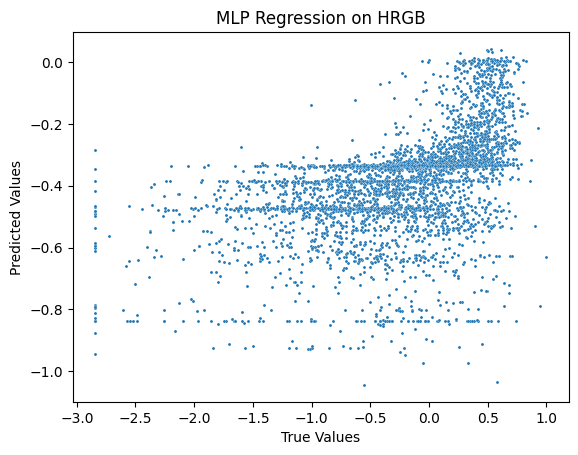

In [416]:
mlp_regression(df_hrgb_features_train, df_hrgb_features_test, \
    'HRGB', mlp_hrgb_search.best_estimator_)

Evaluation metrics for MLP Regression on PCA:
RMSE (Root Mean Square Error): 0.6124
Pearson Correlation Coefficient: 0.5932
Spearman Correlation Coefficient: 0.6442
R2 Score: 0.1439


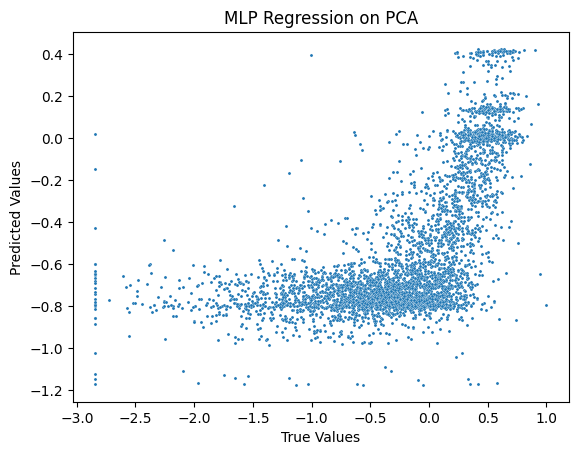

In [417]:
mlp_regression(df_pca_features_train, df_pca_features_test, \
    'PCA', mlp_pca_search.best_estimator_)

Evaluation metrics for MLP Regression on GLCM:
RMSE (Root Mean Square Error): 0.6748
Pearson Correlation Coefficient: 0.0113
Spearman Correlation Coefficient: -0.5744
R2 Score: -0.0396


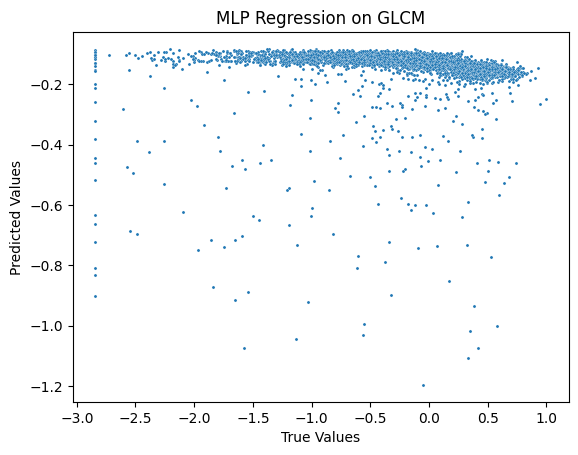

In [418]:
mlp_regression(df_glcm_features_train, df_glcm_features_test, \
    'GLCM', mlp_glcm_search.best_estimator_)

Evaluation metrics for MLP Regression on HRGB, PCA & GLCM:
RMSE (Root Mean Square Error): 0.6101
Pearson Correlation Coefficient: 0.5997
Spearman Correlation Coefficient: 0.7026
R2 Score: 0.1502


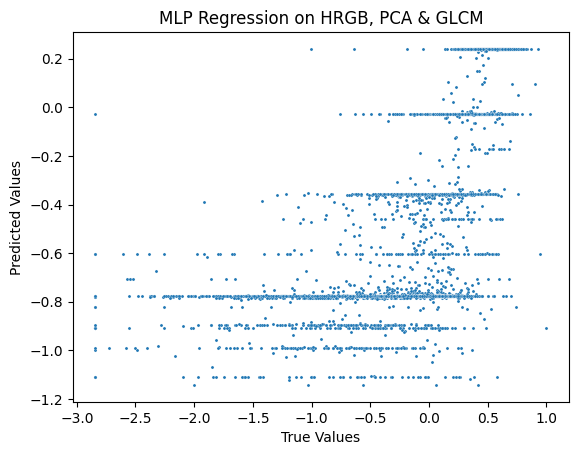

In [427]:
mlp_regression(df_combine_features_train, df_combine_features_test, \
    'HRGB, PCA & GLCM', mlp_combine_search.best_estimator_)

Evaluation metrics for MLP Regression on Transfer Learning:
RMSE (Root Mean Square Error): 0.6318
Pearson Correlation Coefficient: 0.3584
Spearman Correlation Coefficient: 0.4413
R2 Score: 0.0889


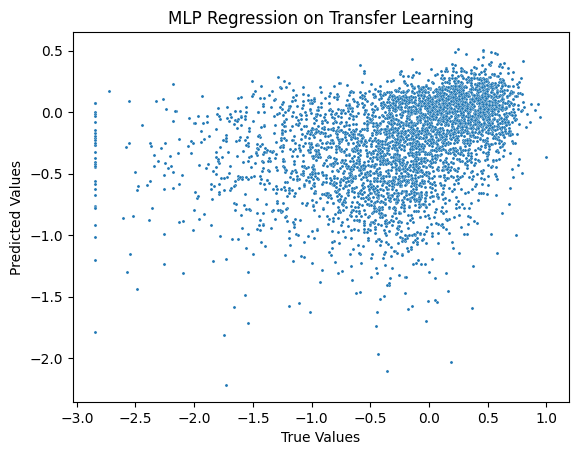

In [419]:
mlp_regression(df_transfer_features_train, df_transfer_features_test, \
    'Transfer Learning', mlp_transfer_search.best_estimator_)

Applying MLP on GLCM and transferred features is not effective either (close to or sometimes even worse than predicting mean value). HRGB and PCA features are slightly better, though not at all satisfying, with R2 Score only above 0.1. Combining HRGB, PCA and GLCM improves the optimal performance but still worse than OLS.

We also try using a pipeline where a MinMaxScaler is added before the regressor and see if that makes any difference.

In [18]:
def grid_search_w_scaler(regressor, param_grid, df):
    # Initialize GridSearchCV
    features = df.drop('NESTIN', axis=1)
    target = df['NESTIN']

    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', regressor)
    ])

    # Apply leave one specimen out cross-validation
    grid_search_cv = GridSearchCV(pipeline, param_grid=param_grid, \
        cv=GroupKFold(n_splits=3).split(X=features, y=target, groups=df.index.str.split('_').str[0].tolist()),
            scoring='r2', n_jobs=-1, error_score=float('-inf'), verbose=1)
    
    # Perform grid search on the training data
    grid_search_cv.fit(features, target)
    
    return grid_search_cv

In [420]:
# Define the parameter grid for MLP
param_grid_mlp_w_scaler = {
    'regressor__activation': ['relu', 'logistic', 'tanh'],
    'regressor__solver': ['sgd', 'adam', 'lbfgs'],
    'regressor__alpha': [0.01, 0.1, 1],
    'regressor__learning_rate': ['constant', 'adaptive'],
    'regressor__hidden_layer_sizes': [(10,), (50,), (100,), (10, 10), (50, 50), (100, 100)]
}

In [430]:
# Create the MLP regressor and perform grid search
mlp_hrgb_search_w_scaler = grid_search_w_scaler(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp_w_scaler, df_hrgb_features_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [431]:
relevant_info = sorted_score(mlp_hrgb_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__activation  regressor__alpha regressor__hidden_layer_sizes  \
0                  relu              0.10                      (10, 10)   
1                  relu              0.01                      (10, 10)   
2                  relu              0.10                      (10, 10)   
3                  relu              0.01                      (10, 10)   
4                  relu              1.00                      (10, 10)   
5                  relu              1.00                      (10, 10)   
6                  relu              1.00                      (10, 10)   
7                  relu              1.00                      (10, 10)   
8                  relu              1.00                         (10,)   
9              logistic              1.00                    (100, 100)   

  regressor__learning_rate regressor__solver   mean_r2    std_r2  
0                 adaptive               sgd  0.138605  0.039971  
1                 adaptive               sgd  0.136955  0.044153  
2                 constant               sgd  0.136845  0.041895  
3                 constant               sgd  0.135149  0.046188  
4                 adaptive               sgd  0.131725  0.027239  
5                 constant               sgd  0.131568  0.025197  
6                 constant              adam  0.121198  0.092031  
7                 adaptive              adam  0.121198  0.092031  
8                 adaptive               sgd  0.104916  0.159761  
9                 constant             lbfgs  0.104205  0.111173

In [432]:
# Create the MLP regressor and perform grid search
mlp_pca_search_w_scaler = grid_search_w_scaler(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp_w_scaler, df_pca_features_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [433]:
relevant_info = sorted_score(mlp_pca_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__activation  regressor__alpha regressor__hidden_layer_sizes  \
0              logistic               1.0                         (10,)   
1              logistic               1.0                         (10,)   
2              logistic               1.0                        (100,)   
3              logistic               1.0                        (100,)   
4              logistic               1.0                         (50,)   
5              logistic               1.0                         (50,)   
6                  relu               1.0                         (10,)   
7                  relu               1.0                         (10,)   
8                  tanh               0.1                      (10, 10)   
9                  tanh               0.1                      (10, 10)   

  regressor__learning_rate regressor__solver   mean_r2    std_r2  
0                 constant              adam  0.109893  0.064233  
1                 adaptive              adam  0.109893  0.064233  
2                 constant              adam  0.108420  0.067037  
3                 adaptive              adam  0.108420  0.067037  
4                 constant              adam  0.105674  0.066174  
5                 adaptive              adam  0.105674  0.066174  
6                 constant               sgd  0.090312  0.196855  
7                 adaptive               sgd  0.087979  0.200852  
8                 constant              adam  0.079986  0.152112  
9                 adaptive              adam  0.079986  0.152112

In [434]:
# Create the MLP regressor and perform grid search
mlp_glcm_search_w_scaler = grid_search_w_scaler(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp_w_scaler, df_glcm_features_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [435]:
relevant_info = sorted_score(mlp_glcm_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__activation  regressor__alpha regressor__hidden_layer_sizes  \
0                  relu              1.00                         (50,)   
1                  relu              1.00                         (50,)   
2                  relu              1.00                        (100,)   
3                  relu              1.00                        (100,)   
4                  tanh              1.00                         (50,)   
5                  tanh              1.00                        (100,)   
6                  tanh              1.00                         (50,)   
7                  tanh              1.00                        (100,)   
8                  relu              0.10                         (50,)   
9                  relu              0.01                         (50,)   

  regressor__learning_rate regressor__solver   mean_r2    std_r2  
0                 adaptive               sgd  0.088097  0.059841  
1                 constant               sgd  0.087306  0.058738  
2                 constant               sgd  0.083022  0.057300  
3                 adaptive               sgd  0.082541  0.058430  
4                 constant               sgd  0.071428  0.080436  
5                 constant               sgd  0.069420  0.078759  
6                 adaptive               sgd  0.068187  0.083648  
7                 adaptive               sgd  0.066926  0.082427  
8                 constant               sgd  0.065488  0.065243  
9                 constant               sgd  0.064768  0.070895

In [436]:
# Create the MLP regressor and perform grid search
mlp_combine_search_w_scaler = grid_search_w_scaler(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp_w_scaler, df_combine_features_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [437]:
relevant_info = sorted_score(mlp_combine_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__activation  regressor__alpha regressor__hidden_layer_sizes  \
0              logistic              1.00                         (10,)   
1              logistic              1.00                         (10,)   
2                  relu              1.00                         (50,)   
3                  relu              1.00                         (50,)   
4                  tanh              0.01                         (10,)   
5                  tanh              0.01                         (10,)   
6                  tanh              0.10                    (100, 100)   
7                  tanh              0.10                    (100, 100)   
8                  tanh              0.10                         (10,)   
9                  tanh              0.10                         (10,)   

  regressor__learning_rate regressor__solver   mean_r2    std_r2  
0                 constant               sgd  0.088909  0.084262  
1                 adaptive               sgd  0.086696  0.085543  
2                 adaptive               sgd  0.075077  0.123214  
3                 constant               sgd  0.074315  0.123811  
4                 constant              adam  0.062904  0.141072  
5                 adaptive              adam  0.062904  0.141072  
6                 constant              adam  0.062626  0.175309  
7                 adaptive              adam  0.062626  0.175309  
8                 constant              adam  0.062335  0.155857  
9                 adaptive              adam  0.062335  0.155857

In [438]:
# Create the MLP regressor and perform grid search
mlp_transfer_search_w_scaler = grid_search_w_scaler(MLPRegressor(random_state=42, max_iter=1000), \
    param_grid_mlp_w_scaler, df_transfer_features_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [478]:
relevant_info = sorted_score(mlp_transfer_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__activation  regressor__alpha regressor__hidden_layer_sizes  \
0              logistic                 1                        (100,)   
1              logistic                 1                        (100,)   
2              logistic                 1                         (50,)   
3              logistic                 1                         (50,)   
4              logistic                 1                         (10,)   
5              logistic                 1                         (10,)   
6              logistic                 1                        (100,)   
7              logistic                 1                        (100,)   
8              logistic                 1                         (50,)   
9              logistic                 1                         (50,)   

  regressor__learning_rate regressor__solver   mean_r2    std_r2  
0                 constant              adam  0.163908  0.105445  
1                 adaptive              adam  0.163908  0.105445  
2                 constant              adam  0.157866  0.105580  
3                 adaptive              adam  0.157866  0.105580  
4                 constant              adam  0.152568  0.097937  
5                 adaptive              adam  0.152568  0.097937  
6                 constant               sgd  0.147261  0.105778  
7                 adaptive               sgd  0.143074  0.108038  
8                 constant               sgd  0.128119  0.086558  
9                 adaptive               sgd  0.127551  0.088788

Evaluation metrics for MLP Regression on HRGB:
RMSE (Root Mean Square Error): 0.5906
Pearson Correlation Coefficient: 0.6617
Spearman Correlation Coefficient: 0.7336
R2 Score: 0.2036


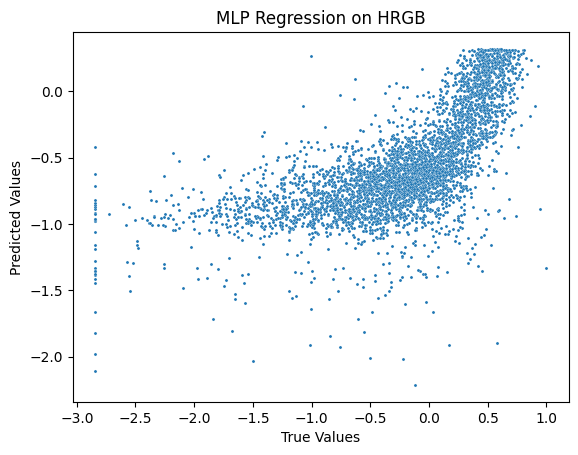

In [440]:
mlp_regression(df_hrgb_features_train, df_hrgb_features_test, \
    'HRGB', mlp_hrgb_search_w_scaler.best_estimator_)

Evaluation metrics for MLP Regression on PCA:
RMSE (Root Mean Square Error): 0.5839
Pearson Correlation Coefficient: 0.6466
Spearman Correlation Coefficient: 0.7392
R2 Score: 0.2217


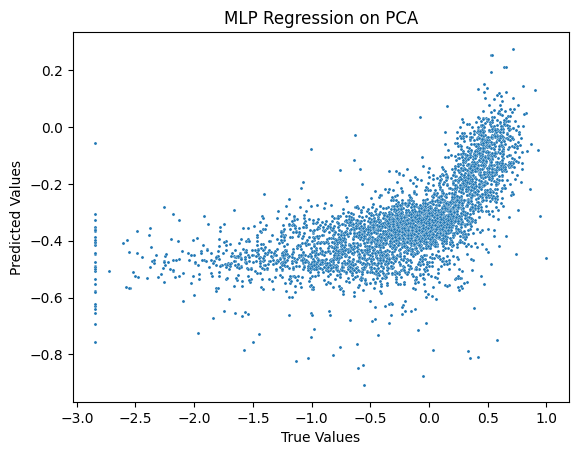

In [441]:
mlp_regression(df_pca_features_train, df_pca_features_test, \
    'PCA', mlp_pca_search_w_scaler.best_estimator_)

Evaluation metrics for MLP Regression on GLCM:
RMSE (Root Mean Square Error): 0.6686
Pearson Correlation Coefficient: 0.0383
Spearman Correlation Coefficient: -0.5746
R2 Score: -0.0206


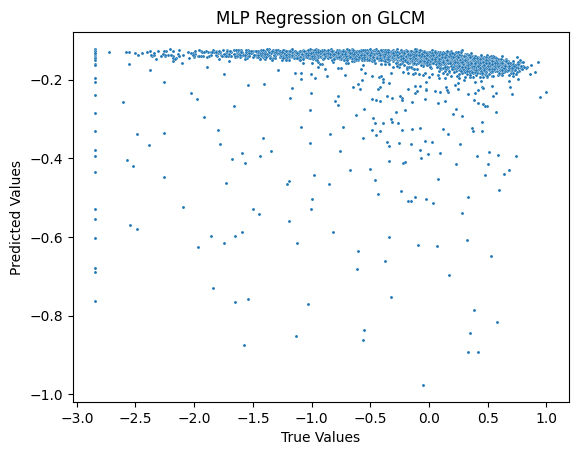

In [442]:
mlp_regression(df_glcm_features_train, df_glcm_features_test, \
    'GLCM', mlp_glcm_search_w_scaler.best_estimator_)

Evaluation metrics for MLP Regression on HRGB, PCA & GLCM:
RMSE (Root Mean Square Error): 0.5927
Pearson Correlation Coefficient: 0.6434
Spearman Correlation Coefficient: 0.7348
R2 Score: 0.1980


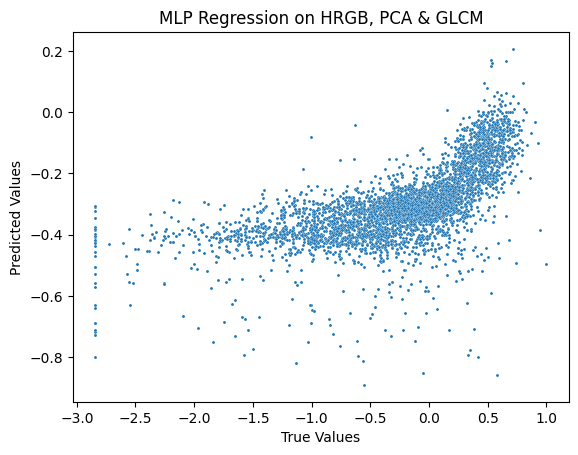

In [443]:
mlp_regression(df_combine_features_train, df_combine_features_test, \
    'HRGB, PCA & GLCM', mlp_combine_search_w_scaler.best_estimator_)

Evaluation metrics for MLP Regression on Transfer Learning:
RMSE (Root Mean Square Error): 0.5865
Pearson Correlation Coefficient: 0.4708
Spearman Correlation Coefficient: 0.5601
R2 Score: 0.2147


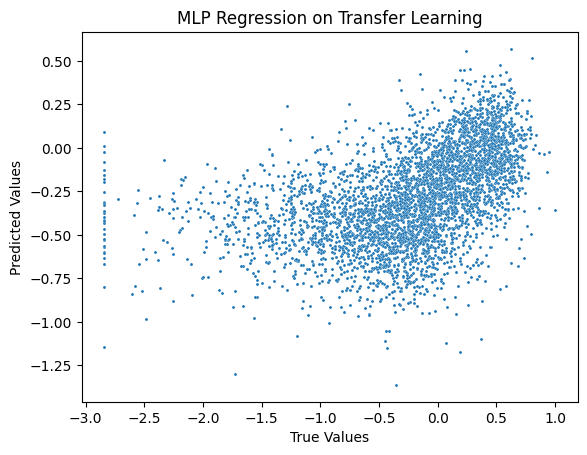

In [444]:
mlp_regression(df_transfer_features_train, df_transfer_features_test, \
    'Transfer Learning', mlp_transfer_search_w_scaler.best_estimator_)

- ***Support Vector Regression (SVR)***

Based on previous steps (and Assignment 1 where we worked with Support Vector Machine for classification task), preprocessing the data with a scaler would probably improve the performance, so we try grid search both with and without scaling.

In [14]:
# Define the parameter grid for SVR
param_grid_svr = [
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10]
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10],
        'degree': [2, 3]
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }
]

In [497]:
# Create the SVR regressor and perform grid search
svr_hrgb_search = grid_search(SVR(max_iter=10000), param_grid_svr, df_hrgb_features_train)

In [512]:
relevant_info = sorted_score(svr_hrgb_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

C  gamma kernel   mean_r2    std_r2  degree
0   0.1  scale    rbf  0.113472  0.030320     NaN
1  10.0  scale    rbf  0.109494  0.063704     NaN
2   1.0  scale    rbf  0.028283  0.174197     NaN
3   1.0   auto    rbf -0.008805  0.006315     NaN
4   0.1   auto    rbf -0.032670  0.013992     NaN
5  10.0   auto    rbf -0.035469  0.031551     NaN
6   1.0    NaN   poly -0.292495  0.615050     3.0
7   0.1    NaN   poly -0.375040  0.700816     2.0
8   1.0    NaN   poly -0.400573  0.766838     2.0
9   0.1    NaN   poly -0.498255  0.839743     3.0

In [499]:
# Create the SVR regressor and perform grid search
svr_pca_search = grid_search(SVR(max_iter=10000), param_grid_svr, df_pca_features_train)

In [513]:
relevant_info = sorted_score(svr_pca_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

C  gamma kernel   mean_r2    std_r2  degree
0   0.1  scale    rbf  0.029497  0.107381     NaN
1   1.0   auto    rbf -0.008828  0.006253     NaN
2   0.1   auto    rbf -0.032733  0.014002     NaN
3  10.0   auto    rbf -0.035361  0.031470     NaN
4   1.0  scale    rbf -0.105410  0.245976     NaN
5  10.0  scale    rbf -0.341443  0.524977     NaN
6   0.1    NaN   poly -0.456316  0.496560     2.0
7   1.0    NaN   poly -0.631281  0.673140     2.0
8  10.0    NaN   poly -0.882687  1.005113     2.0
9   1.0    NaN   poly -2.004164  1.397234     3.0

In [501]:
# Create the SVR regressor and perform grid search
svr_glcm_search = grid_search(SVR(max_iter=10000), param_grid_svr, df_glcm_features_train)

In [514]:
relevant_info = sorted_score(svr_glcm_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

C  kernel   mean_r2    std_r2  gamma  degree
0   0.1  linear  0.128007  0.096842    NaN     NaN
1   0.1     rbf  0.126869  0.095921   auto     NaN
2   1.0  linear  0.116299  0.086479    NaN     NaN
3   1.0     rbf  0.095244  0.082624   auto     NaN
4  10.0  linear  0.084413  0.086092    NaN     NaN
5   0.1    poly  0.033429  0.121462    NaN     2.0
6   0.1     rbf -0.002281  0.137683  scale     NaN
7   1.0    poly -0.030765  0.195077    NaN     2.0
8  10.0     rbf -0.069049  0.246908   auto     NaN
9   1.0     rbf -0.222841  0.427399  scale     NaN

In [503]:
# Create the SVR regressor and perform grid search
svr_combine_search = grid_search(SVR(max_iter=10000), param_grid_svr, df_combine_features_train)

In [515]:
relevant_info = sorted_score(svr_combine_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

C  gamma kernel   mean_r2    std_r2  degree
0   0.1  scale    rbf  0.060876  0.073585     NaN
1   1.0   auto    rbf -0.008790  0.006325     NaN
2   0.1    NaN   poly -0.010178  0.130312     2.0
3   0.1   auto    rbf -0.032678  0.013997     NaN
4  10.0   auto    rbf -0.035392  0.031455     NaN
5   1.0  scale    rbf -0.159888  0.305288     NaN
6   1.0    NaN   poly -0.176178  0.308600     3.0
7   0.1    NaN   poly -0.215669  0.417927     3.0
8   1.0    NaN   poly -0.275077  0.441724     2.0
9  10.0  scale    rbf -0.426923  0.656877     NaN

In [505]:
# Create the SVR regressor and perform grid search
svr_transfer_search = grid_search(SVR(max_iter=10000), param_grid_svr, df_transfer_features_train)

In [516]:
relevant_info = sorted_score(svr_transfer_search)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

C  degree kernel   mean_r2    std_r2  gamma
0   0.1     2.0   poly  0.162069  0.052423    NaN
1   1.0     2.0   poly  0.158258  0.076200    NaN
2   0.1     NaN    rbf  0.144144  0.076126  scale
3   0.1     3.0   poly  0.127874  0.053555    NaN
4   1.0     NaN    rbf  0.083324  0.175242  scale
5   1.0     3.0   poly  0.072148  0.117556    NaN
6   1.0     NaN    rbf -0.008784  0.006326   auto
7  10.0     2.0   poly -0.030448  0.221946    NaN
8   0.1     NaN    rbf -0.032678  0.013997   auto
9  10.0     NaN    rbf -0.035375  0.031439   auto

In [19]:
def svr_regression(df_train, df_test, df_name, model):
    # Split the data into training and validation
    X_train, y_train = df_train.drop('NESTIN', axis=1), df_train['NESTIN']
    X_test, y_test = df_test.drop('NESTIN', axis=1), df_test['NESTIN']

    # SVR Regression Model
    model.fit(X_train, y_train)

    # Predict the target variable on the test set
    y_pred_mlp = model.predict(X_test)
    evaluation(y_test, y_pred_mlp, 'SVR Regression', df_name)

Evaluation metrics for SVR Regression on HRGB:
RMSE (Root Mean Square Error): 0.5666
Pearson Correlation Coefficient: 0.5875
Spearman Correlation Coefficient: 0.6543
R2 Score: 0.2670


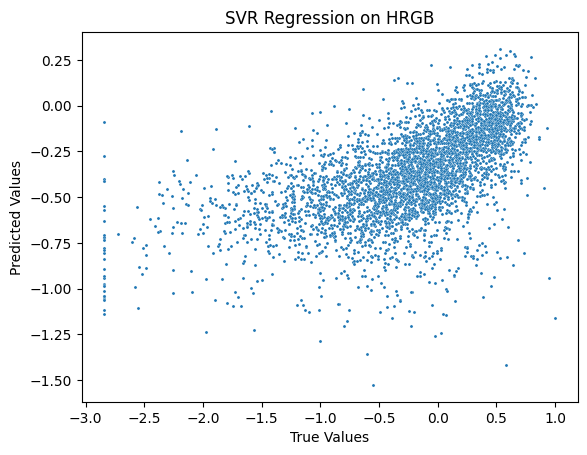

In [517]:
svr_regression(df_hrgb_features_train, df_hrgb_features_test, \
    'HRGB', svr_hrgb_search.best_estimator_)

Evaluation metrics for SVR Regression on PCA:
RMSE (Root Mean Square Error): 0.6144
Pearson Correlation Coefficient: 0.5518
Spearman Correlation Coefficient: 0.6039
R2 Score: 0.1384


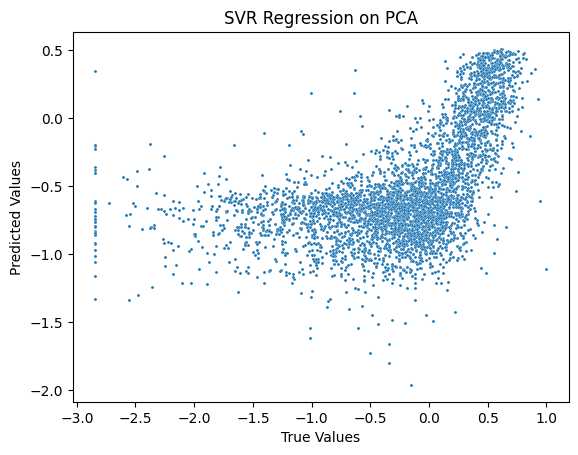

In [518]:
svr_regression(df_pca_features_train, df_pca_features_test, \
    'PCA', svr_pca_search.best_estimator_)

Evaluation metrics for SVR Regression on GLCM:
RMSE (Root Mean Square Error): 0.7001
Pearson Correlation Coefficient: 0.0116
Spearman Correlation Coefficient: -0.5744
R2 Score: -0.1190


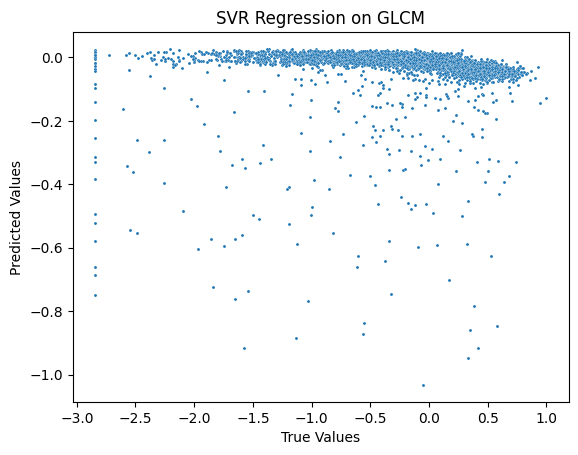

In [509]:
svr_regression(df_glcm_features_train, df_glcm_features_test, \
    'GLCM', svr_glcm_search.best_estimator_)

Evaluation metrics for SVR Regression on HRGB, PCA & GLCM:
RMSE (Root Mean Square Error): 0.5757
Pearson Correlation Coefficient: 0.6001
Spearman Correlation Coefficient: 0.6627
R2 Score: 0.2435


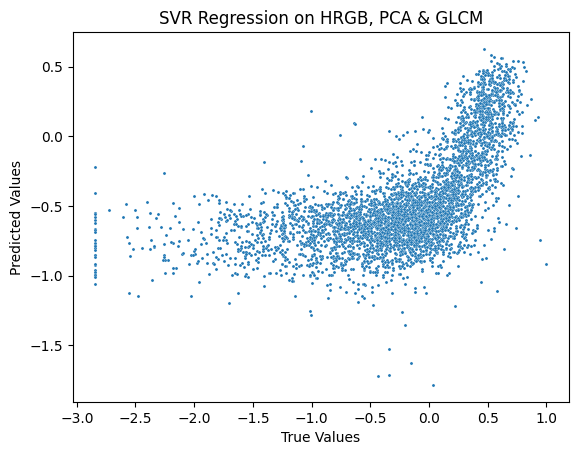

In [510]:
svr_regression(df_combine_features_train, df_combine_features_test, \
    'HRGB, PCA & GLCM', svr_combine_search.best_estimator_)

Evaluation metrics for SVR Regression on Transfer Learning:
RMSE (Root Mean Square Error): 0.6011
Pearson Correlation Coefficient: 0.4240
Spearman Correlation Coefficient: 0.5858
R2 Score: 0.1751


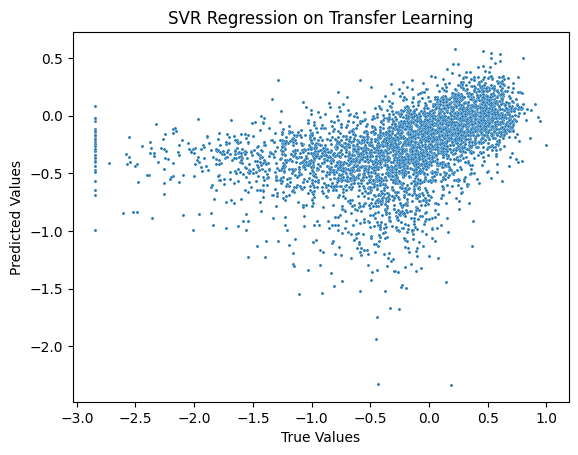

In [511]:
svr_regression(df_transfer_features_train, df_transfer_features_test, \
    'Transfer Learning', svr_transfer_search.best_estimator_)

The best performance for SVR without scaling is on HRGB features with a R2 Score of 0.267.

In [17]:
# Define the parameter grid for SVR
param_grid_svr_w_scaler = [
    {
        'regressor__kernel': ['linear'],
        'regressor__C': [0.1, 1, 10]
    },
    {
        'regressor__kernel': ['poly'],
        'regressor__C': [0.1, 1, 10],
        'regressor__degree': [2, 3]
    },
    {
        'regressor__kernel': ['rbf'],
        'regressor__C': [0.1, 1, 10],
        'regressor__gamma': ['scale', 'auto']
    }
]

In [481]:
# Create the SVR regressor and perform grid search
svr_hrgb_search_w_scaler = grid_search_w_scaler(SVR(max_iter=10000), \
    param_grid_svr_w_scaler, df_hrgb_features_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [486]:
relevant_info = sorted_score(svr_hrgb_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__C regressor__gamma regressor__kernel   mean_r2    std_r2  \
0           1.0             auto               rbf  0.139850  0.063350   
1           0.1             auto               rbf  0.041778  0.191045   
2          10.0              NaN            linear  0.040963  0.112778   
3           0.1              NaN              poly  0.021691  0.188027   
4          10.0             auto               rbf -0.015279  0.220894   
5           0.1            scale               rbf -0.036519  0.137570   
6           1.0              NaN            linear -0.066301  0.307521   
7           0.1              NaN            linear -0.117187  0.431981   
8           1.0            scale               rbf -0.134192  0.207476   
9           1.0              NaN              poly -0.193904  0.427089   

   regressor__degree  
0                NaN  
1                NaN  
2                NaN  
3                2.0  
4                NaN  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                2.0

In [482]:
# Create the SVR regressor and perform grid search
svr_pca_search_w_scaler = grid_search_w_scaler(SVR(max_iter=10000), \
    param_grid_svr_w_scaler, df_pca_features_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [487]:
relevant_info = sorted_score(svr_pca_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__C regressor__gamma regressor__kernel   mean_r2    std_r2  \
0           1.0             auto               rbf  0.097957  0.092510   
1           1.0              NaN              poly  0.081527  0.228666   
2           0.1             auto               rbf  0.075086  0.111315   
3           0.1            scale               rbf  0.061624  0.094589   
4           1.0            scale               rbf  0.028575  0.131873   
5           0.1              NaN            linear -0.100661  0.396200   
6           1.0              NaN            linear -0.125609  0.438616   
7          10.0             auto               rbf -0.131191  0.344912   
8          10.0              NaN            linear -0.132525  0.449139   
9           0.1              NaN              poly -0.205528  0.580763   

   regressor__degree  
0                NaN  
1                2.0  
2                NaN  
3                NaN  
4                NaN  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                2.0

In [483]:
# Create the SVR regressor and perform grid search
svr_glcm_search_w_scaler = grid_search_w_scaler(SVR(max_iter=10000), \
    param_grid_svr_w_scaler, df_glcm_features_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [488]:
relevant_info = sorted_score(svr_glcm_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__C regressor__kernel   mean_r2    std_r2 regressor__gamma  \
0           0.1            linear  0.120429  0.088770              NaN   
1           0.1               rbf  0.115827  0.085489             auto   
2           1.0            linear  0.052693  0.098988              NaN   
3           1.0               rbf  0.034663  0.118657             auto   
4           0.1              poly  0.022006  0.127699              NaN   
5           0.1               rbf -0.003247  0.135727            scale   
6          10.0               rbf -0.035235  0.198690             auto   
7          10.0            linear -0.044819  0.214445              NaN   
8           1.0               rbf -0.178168  0.371425            scale   
9          10.0               rbf -0.384353  0.677291            scale   

   regressor__degree  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                2.0  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                NaN

In [484]:
# Create the SVR regressor and perform grid search
svr_combine_search_w_scaler = grid_search_w_scaler(SVR(max_iter=10000), \
    param_grid_svr_w_scaler, df_combine_features_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [489]:
relevant_info = sorted_score(svr_combine_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__C regressor__gamma regressor__kernel   mean_r2    std_r2  \
0           1.0             auto               rbf  0.141626  0.072807   
1          10.0              NaN            linear  0.036853  0.124782   
2           0.1             auto               rbf  0.023009  0.202488   
3          10.0             auto               rbf  0.018062  0.187194   
4           0.1            scale               rbf -0.020818  0.145198   
5           0.1              NaN              poly -0.025496  0.261340   
6           1.0              NaN            linear -0.083468  0.315164   
7           0.1              NaN            linear -0.118867  0.388323   
8          10.0              NaN              poly -0.133388  0.269846   
9           1.0            scale               rbf -0.158655  0.237795   

   regressor__degree  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
5                2.0  
6                NaN  
7                NaN  
8                2.0  
9                NaN

In [485]:
# Create the SVR regressor and perform grid search
svr_transfer_search_w_scaler = grid_search_w_scaler(SVR(max_iter=10000), \
    param_grid_svr_w_scaler, df_transfer_features_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [490]:
relevant_info = sorted_score(svr_transfer_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__C  regressor__degree regressor__kernel   mean_r2    std_r2  \
0           0.1                2.0              poly  0.185598  0.054845   
1          10.0                NaN               rbf  0.163563  0.106658   
2           1.0                NaN               rbf  0.161945  0.070760   
3           0.1                NaN               rbf  0.157508  0.037584   
4           0.1                3.0              poly  0.153187  0.057407   
5           0.1                NaN            linear  0.146776  0.087636   
6           0.1                NaN               rbf  0.129333  0.059187   
7           1.0                NaN            linear  0.125448  0.111529   
8           1.0                2.0              poly  0.118481  0.078906   
9           1.0                NaN               rbf  0.056204  0.192858   

  regressor__gamma  
0              NaN  
1             auto  
2             auto  
3             auto  
4              NaN  
5              NaN  
6            scale  
7              NaN  
8              NaN  
9            scale

Evaluation metrics for SVR Regression on HRGB:
RMSE (Root Mean Square Error): 0.5449
Pearson Correlation Coefficient: 0.6635
Spearman Correlation Coefficient: 0.7415
R2 Score: 0.3222


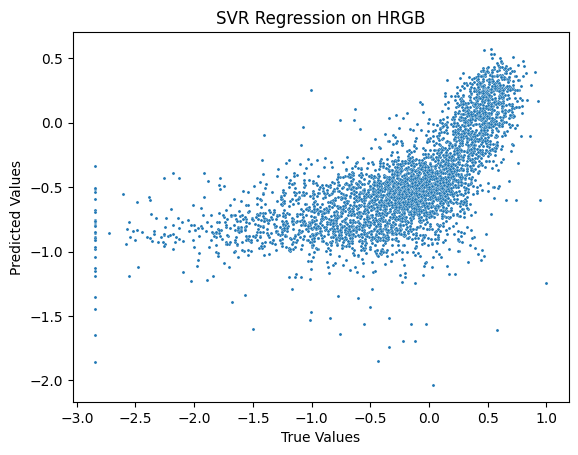

In [491]:
svr_regression(df_hrgb_features_train, df_hrgb_features_test, \
    'HRGB', svr_hrgb_search_w_scaler.best_estimator_)

Evaluation metrics for SVR Regression on PCA:
RMSE (Root Mean Square Error): 0.5785
Pearson Correlation Coefficient: 0.6344
Spearman Correlation Coefficient: 0.7199
R2 Score: 0.2359


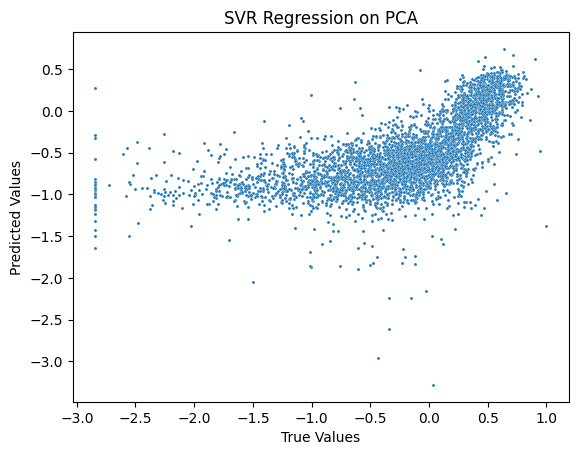

In [492]:
svr_regression(df_pca_features_train, df_pca_features_test, \
    'PCA', svr_pca_search_w_scaler.best_estimator_)

Evaluation metrics for SVR Regression on GLCM:
RMSE (Root Mean Square Error): 0.7009
Pearson Correlation Coefficient: 0.0143
Spearman Correlation Coefficient: -0.5743
R2 Score: -0.1214


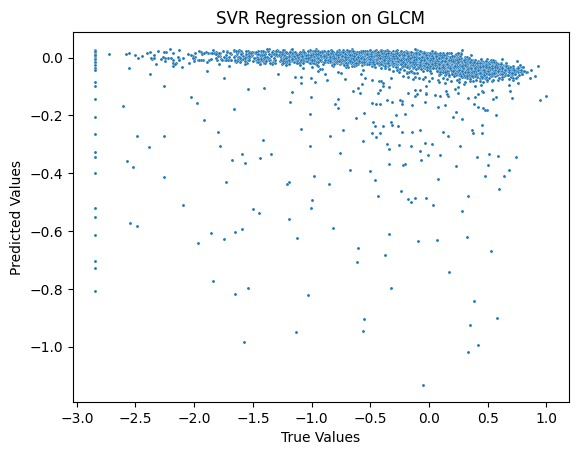

In [493]:
svr_regression(df_glcm_features_train, df_glcm_features_test, \
    'GLCM', svr_glcm_search_w_scaler.best_estimator_)

Evaluation metrics for SVR Regression on HRGB, PCA & GLCM:
RMSE (Root Mean Square Error): 0.5414
Pearson Correlation Coefficient: 0.6661
Spearman Correlation Coefficient: 0.7435
R2 Score: 0.3309


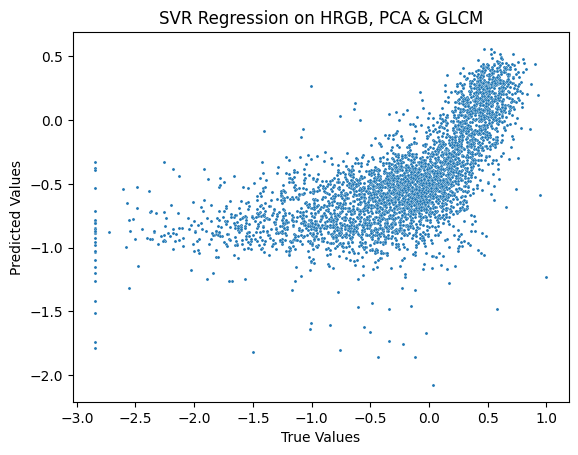

In [494]:
svr_regression(df_combine_features_train, df_combine_features_test, \
    'HRGB, PCA & GLCM', svr_combine_search_w_scaler.best_estimator_)

Evaluation metrics for SVR Regression on Transfer Learning:
RMSE (Root Mean Square Error): 0.6080
Pearson Correlation Coefficient: 0.4080
Spearman Correlation Coefficient: 0.5654
R2 Score: 0.1561


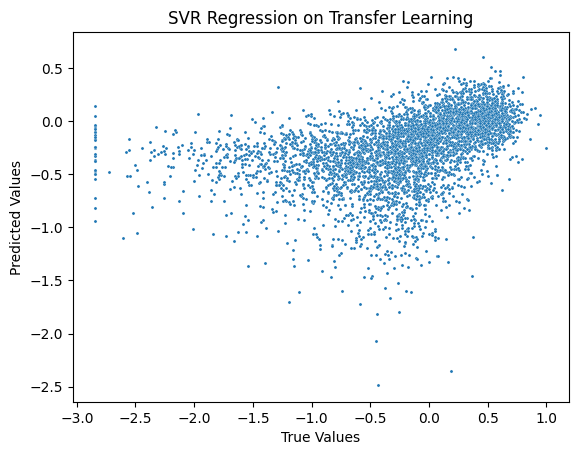

In [495]:
svr_regression(df_transfer_features_train, df_transfer_features_test, \
    'Transfer Learning', svr_transfer_search_w_scaler.best_estimator_)

The best performance for SVR with scaling is on combined HRGB, PCA and GLCM features with a R2 Score of 0.33.

## Question No. 3: Convolutional Neural Networks

*(i) Develop a Convolutional Neural Network (CNN) using PyTorch to predict the expression level of NESTIN from input images, following the approach outlined in part (ii) of Question (2). Design the architecture of the CNN to input an image and output a single value representing the NESTIN expression level. You have the freedom to select the structure of the network and the loss functions to be used.  You can use pre-trained models and perform transfer learning if needed.*

*Evaluate your model's performance on the test dataset by creating a scatter plot that compares the true vs. predicted NESTIN expression values. Additionally, quantify your model's accuracy using the following metrics:*

- *RMSE (Root Mean Square Error)*
- *Pearson Correlation Coefficient*
- *Spearman Correlation Coefficient*
- *R2 score*

*Your model will be assessed based on its architecture design and the achieved performance metrics. Aim for the best possible performance on the test set, ensuring that the test data is not used during training. Include in your submission convergence plots that illustrate the change in loss across training epochs, demonstrating how your model's performance improves over time.*

We split the training and validation sets for each sample (A1, B1, D1) by 50-50 percent.

In [9]:
train_datasets = []
val_datasets = []

grouped = df_train.groupby('specimen_id')

for name, group in grouped:
    train_data, val_data = train_test_split(group, test_size=0.5, random_state=42)
    train_datasets.append(train_data)
    val_datasets.append(val_data)

df_train_split = pd.concat(train_datasets, ignore_index=False)
df_val_split = pd.concat(val_datasets, ignore_index=False)

In [5]:
def calculate_mean_and_std(image_folder, dataframe):
    mean = np.zeros(3)
    std = np.zeros(3)

    for index in dataframe.index:
        img_name = index + '.png'
        img_path = os.path.join(image_folder, img_name)
        img = imread(img_path)[:, :, :3]
        img_array = img / 255.0

        mean += np.mean(img_array, axis=(0, 1))
        std += np.std(img_array, axis=(0, 1))

    mean /= len(dataframe)
    std /= len(dataframe)

    return mean, std

In [11]:
mean, std = calculate_mean_and_std(image_folder, df_train_split)

print('Mean:', mean)
print('Std:', std)

Mean: [0.77088048 0.49062467 0.70881397]
Std: [0.14060905 0.18307761 0.1263799 ]


In [6]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 25
batch_size = 16
learning_rate = 0.001

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, dataframe, column, transform=None):
        self.image_folder = image_folder
        self.dataframe = dataframe
        self.transform = transform
        self.column = column

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.index[idx] + '.png'
        img_path = os.path.join(self.image_folder, img_name)
        image = imread(img_path)[:, :, :3] / 255.0
        level = torch.tensor(self.dataframe[self.column].iloc[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, level

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.771, 0.491, 0.709], [0.141, 0.183, 0.126])
])

In [14]:
train_dataset = CustomDataset(image_folder=image_folder,
                              dataframe=df_train_split,
                              column='NESTIN',
                              transform=transform)

val_dataset = CustomDataset(image_folder=image_folder,
                              dataframe=df_val_split,
                              column='NESTIN',
                              transform=transform)

test_dataset = CustomDataset(image_folder=image_folder,
                             dataframe=df_test,
                             column='NESTIN',
                             transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Sequential(
            nn.Linear(64*64*32, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.dropout1(out)
        out = self.layer2(out)
        out = self.dropout2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
# Train the model
def train_model(model, criterion, optimizer, scheduler, train_loader, epoch):
    model.train()
    # total_step = len(train_loader)
    train_loss = 0.0
    count = 0
    predictions = []
    true_levels = []

    for i, (images, levels) in enumerate(train_loader):
        images = images.float().to(device)
        levels = levels.to(device)
        
        # Forward pass
        outputs = model(images).squeeze()
        loss = criterion(outputs, levels)

        predictions.extend(outputs.detach().cpu().numpy())
        true_levels.extend(levels.cpu().numpy())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        count += images.size(0)

        # if (i+1) % 10 == 0:
            # print ('Epoch [{}], Step [{}/{}], Loss: {:.4f}' 
                   # .format(epoch+1, i+1, total_step, loss.item()))
    
    if scheduler:
        scheduler.step()

    # Convert to numpy arrays for easy R2 Score calculation
    predictions = np.array(predictions)
    true_levels = np.array(true_levels)
    r2 = r2_score(true_levels, predictions)

    average_loss = train_loss / count
    return average_loss, r2

In [10]:
# Validate the model
def val_model(model, criterion, val_loader, epoch):
    model.eval()
    test_loss = 0.0
    count = 0
    predictions = []
    true_levels = []

    with torch.no_grad():
        for images, levels in val_loader:
            images = images.float().to(device)
            levels = levels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), levels.squeeze())

            predictions.extend(outputs.cpu().numpy())
            true_levels.extend(levels.cpu().numpy())

            test_loss += loss.item() * images.size(0)
            count += images.size(0)
    
    # Convert to numpy arrays for easy R2 Score calculation
    predictions = np.array(predictions)
    true_levels = np.array(true_levels)
    r2 = r2_score(true_levels, predictions)

    average_loss = test_loss / count
    return average_loss, r2

In [11]:
def train_val(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, path):
    torch.save(model.state_dict(), path)
    best_r2 = 0.0

    # loss across epochs
    train_loss_history = []
    val_loss_history = []
    train_r2_history = []
    val_r2_history = []

    for epoch in range(num_epochs):
        logging.info(f'Training epoch {epoch+1}......')
        train_loss, train_r2 = train_model(model, criterion, optimizer, scheduler, train_loader, epoch)
        val_loss, val_r2 = val_model(model, criterion, val_loader, epoch)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_r2_history.append(train_r2)
        val_r2_history.append(val_r2)

        logging.info(f"Average training loss: {train_loss}; R2: {train_r2}")
        logging.info(f"Average validation loss: {val_loss}; R2: {val_r2}")
            
        # deep copy the model
        if val_r2 > best_r2:
            best_r2 = val_r2
            torch.save(model.state_dict(), path)

    # load best model weights
    model.load_state_dict(torch.load(path))

    return model, train_loss_history, val_loss_history, train_r2_history, val_r2_history

In [13]:
# Test the model
def test_model(model, test_loader):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

    with torch.no_grad():
        predictions = []
        true_levels = []

        for images, levels in test_loader:
            images = images.float().to(device)
            levels = levels.to(device)
            outputs = model(images)

            predictions.extend(outputs.cpu().numpy())
            true_levels.extend(levels.cpu().numpy())

        # Convert to numpy arrays for easy calculation
        predictions = np.array(predictions).reshape(-1)
        true_levels = np.array(true_levels)

        # RMSE (Root Mean Square Error)
        rmse = mean_squared_error(true_levels, predictions, squared=False)
        # Pearson Correlation Coefficient
        pearson_corr, _ = pearsonr(true_levels, predictions)
        # Spearman Correlation Coefficient
        spearman_corr, _ = spearmanr(true_levels, predictions)
        # R2 score
        r2 = r2_score(true_levels, predictions)

        print('RMSE: {:.4f}'.format(rmse))
        print('Pearson Correlation Coefficient: {:.4f}'.format(pearson_corr))
        print('Spearman Correlation Coefficient: {:.4f}'.format(spearman_corr))
        print('R2 score: {:.4f}'.format(r2))
        
        plt.figure()
        sns.scatterplot(x=true_levels, y=predictions, s=5)
        plt.title('True vs. Predicted NESTIN expression values')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.show()

First, we try a simple CNN model. Note that with every epoch, the average Mean Squared Error (MSE) loss during training consistently decreases, while the R2 score steadily improves. However, on the validation set, both the average MSE loss and R2 score fluctuate without showing a clear upward or downward trend. This indicates that our CNN model has poor generalization performance on the regression task. (In Q2, it was observed that a model trained with specimens A1, B1, and D1 performed poorly on specimen C1. However, here we have ensured that the training and validation sets each include half of the image patches from samples A1, B1, and D1. Thus, even more disappointingly, the 'poor generalization performance' is not necessarily due to differences between the samples, but rather to the nature of the task and the model itself!)

In [68]:
model1 = ConvNet().to(device).float()

# Loss and optimizer
criterion1 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=1e-4)

In [69]:
model1, train_loss_history1, val_loss_history1, train_r2_history1, val_r2_history1 = \
    train_val(model1, criterion1, optimizer1, None, train_loader, val_loader, num_epochs, 'model1.pt')

Training epoch 1......


Average training loss: 0.39581114503591996; R2: 0.11664825577376037
Average validation loss: 0.29207898955695744; R2: 0.30878175654642714
Training epoch 2......
Average training loss: 0.31702126350530485; R2: 0.29248761459697814
Average validation loss: 0.2619185486048445; R2: 0.38015781924433345
Training epoch 3......
Average training loss: 0.2657549075820903; R2: 0.4069013332614341
Average validation loss: 0.5396706174890625; R2: -0.27715511214889377
Training epoch 4......
Average training loss: 0.23801833856496993; R2: 0.46880243092113816
Average validation loss: 0.2790873994652798; R2: 0.3395269504591166
Training epoch 5......
Average training loss: 0.16791566265216146; R2: 0.6252541241527974
Average validation loss: 0.4074960195240499; R2: 0.03564209941411789
Training epoch 6......
Average training loss: 0.13607127747799241; R2: 0.6963228456117795
Average validation loss: 0.28572798597738586; R2: 0.3238116967030502
Training epoch 7......
Average training loss: 0.1384773922398918; 

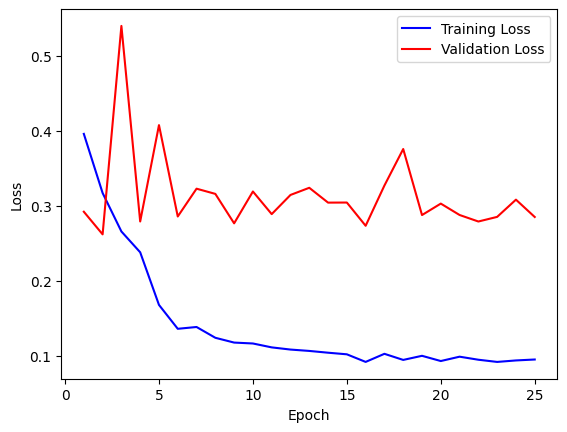

In [70]:
# The convergence plot
plt.plot(range(1, len(train_loss_history1)+1), train_loss_history1, color='blue', label='Training Loss')
plt.plot(range(1, len(val_loss_history1)+1), val_loss_history1, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

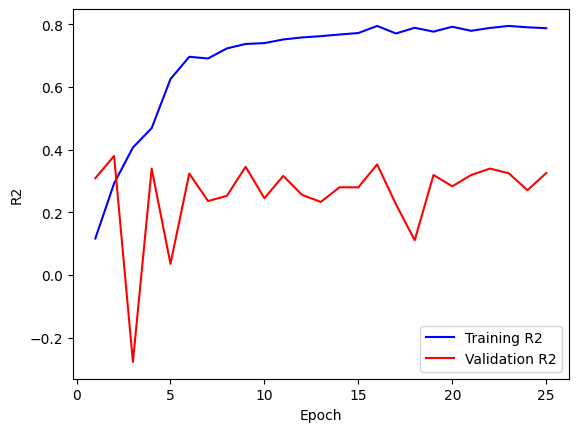

In [71]:
# The convergence plot
plt.plot(range(1, len(train_r2_history1)+1), train_r2_history1, color='blue', label='Training R2')
plt.plot(range(1, len(val_r2_history1)+1), val_r2_history1, color='red', label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.show()

RMSE: 0.5942
Pearson Correlation Coefficient: 0.5327
Spearman Correlation Coefficient: 0.5783
R2 score: 0.1940


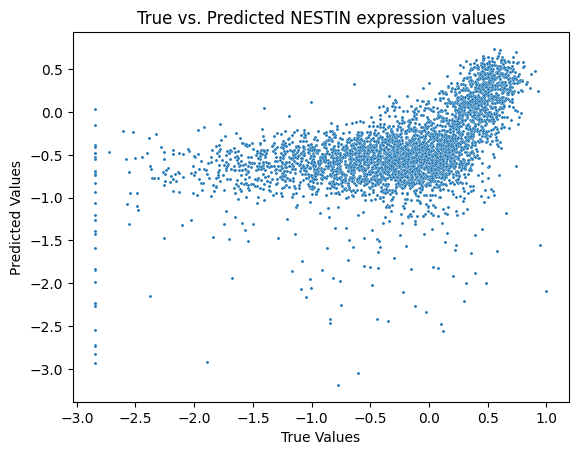

In [72]:
test_model(model1, test_loader)

Next, we attempt to use ResNet as a fixed feature extractor by resetting the final fully connected layer, freezing all the network except the final layer, and performing transfer learning. It can be observed that the average MSE loss and R2 Score on the validation set continue to oscillate. In the end, the model's performance on the test set is close to to the previous CNN model - still falls short of the best performance achieved by OLS, MLP, and SVR in Q2.

In [75]:
model2 = models.resnet18(weights='IMAGENET1K_V1')
for param in model2.parameters():
    param.requires_grad = False

num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 1)
model2 = model2.to(device).float()

# Loss and optimizer
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.fc.parameters(), lr=learning_rate, weight_decay=1e-4)

In [76]:
model2, train_loss_history2, val_loss_history2, train_r2_history2, val_r2_history2 = \
    train_val(model2, criterion2, optimizer2, None, train_loader, val_loader, num_epochs, 'model2.pt')

Training epoch 1......


Average training loss: 0.374078180536705; R2: 0.1651507997469548
Average validation loss: 0.30208890062387456; R2: 0.28509285230640125
Training epoch 2......
Average training loss: 0.3192163894985624; R2: 0.28758863570869997
Average validation loss: 0.26440388073551274; R2: 0.3742761660798185
Training epoch 3......
Average training loss: 0.28809880496409684; R2: 0.3570353306807672
Average validation loss: 0.25010364816688363; R2: 0.408118325518108
Training epoch 4......
Average training loss: 0.29596729141134054; R2: 0.33947482656118744
Average validation loss: 0.25210041812793693; R2: 0.40339286926666873
Training epoch 5......
Average training loss: 0.2859937473230823; R2: 0.3617332841440042
Average validation loss: 0.2768355043149114; R2: 0.3448561648927855
Training epoch 6......
Average training loss: 0.28956698203951586; R2: 0.3537587188973188
Average validation loss: 0.2414337101221743; R2: 0.4286361200040517
Training epoch 7......
Average training loss: 0.28373133426400254; R2: 0

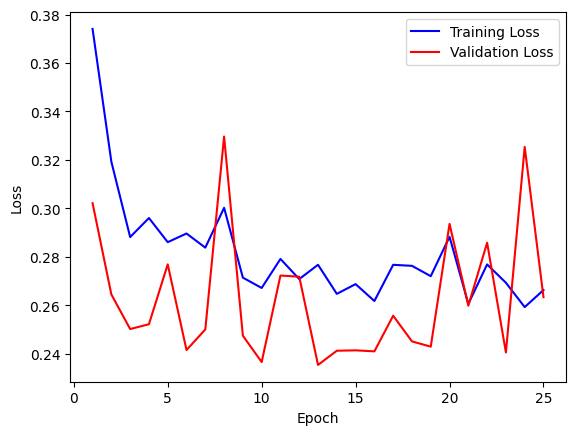

In [77]:
# The convergence plot
plt.plot(range(1, len(train_loss_history2)+1), train_loss_history2, color='blue', label='Training Loss')
plt.plot(range(1, len(val_loss_history2)+1), val_loss_history2, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

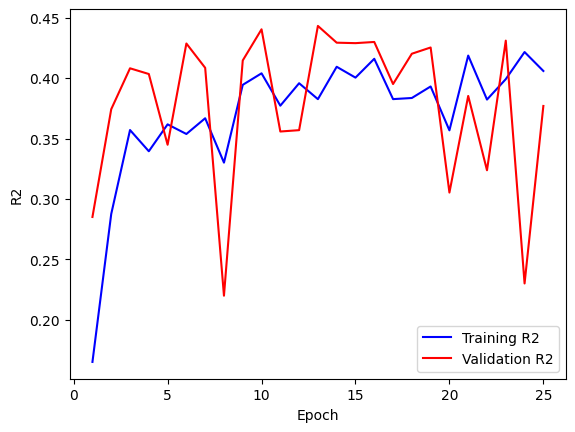

In [78]:
# The convergence plot
plt.plot(range(1, len(train_r2_history2)+1), train_r2_history2, color='blue', label='Training R2')
plt.plot(range(1, len(val_r2_history2)+1), val_r2_history2, color='red', label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.show()

RMSE: 0.5977
Pearson Correlation Coefficient: 0.5529
Spearman Correlation Coefficient: 0.6112
R2 score: 0.1844


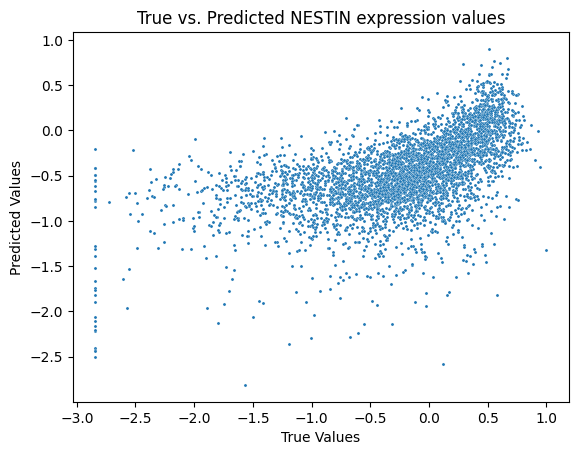

In [79]:
test_model(model2, test_loader)

Due to consistently poor generalization performance of the model, we suspect the presence of overfitting issues. To mitigate this, we attempt to address the problem by replacing the Adam optimizer with SGD with Momentum.

The convergence plot looks better but the performance on test dataset does not improve.

In [14]:
model3 = models.resnet18(weights='IMAGENET1K_V1')
for param in model3.parameters():
    param.requires_grad = False

num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, 1)
model3 = model3.to(device).float()

# Loss and optimizer
criterion3 = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer3 = optim.SGD(model3.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=7, gamma=0.1)

In [15]:
model3, train_loss_history3, val_loss_history3, train_r2_history3, val_r2_history3 = \
    train_val(model3, criterion3, optimizer3, scheduler3, train_loader, val_loader, num_epochs, 'model3.pt')

Training epoch 1......


Average training loss: 0.48925552177202725; R2: -0.09189629237214314
Average validation loss: 0.5050347618421769; R2: -0.19518777923081188
Training epoch 2......
Average training loss: 0.4289861048647365; R2: 0.04260999828550327
Average validation loss: 0.4193128652106823; R2: 0.007676997863719337
Training epoch 3......
Average training loss: 0.3926136177078224; R2: 0.12378433361956653
Average validation loss: 0.3653951542150431; R2: 0.13527572482845063
Training epoch 4......
Average training loss: 0.4083719683434679; R2: 0.08861562804583112
Average validation loss: 1.0438373450949803; R2: -1.4702886547140679
Training epoch 5......
Average training loss: 0.4448129593862771; R2: 0.007288412910655961
Average validation loss: 0.4440229915938873; R2: -0.0508006396923093
Training epoch 6......
Average training loss: 0.4069491116699983; R2: 0.09179108540895786
Average validation loss: 0.41151850899211445; R2: 0.026122689268092247
Training epoch 7......
Average training loss: 0.39043685838142

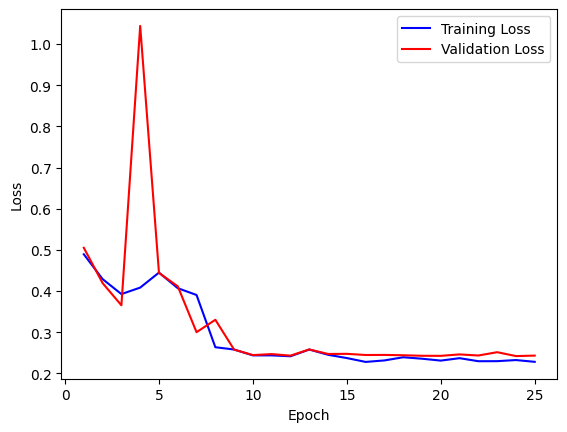

In [16]:
# The convergence plot
plt.plot(range(1, len(train_loss_history3)+1), train_loss_history3, color='blue', label='Training Loss')
plt.plot(range(1, len(val_loss_history3)+1), val_loss_history3, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

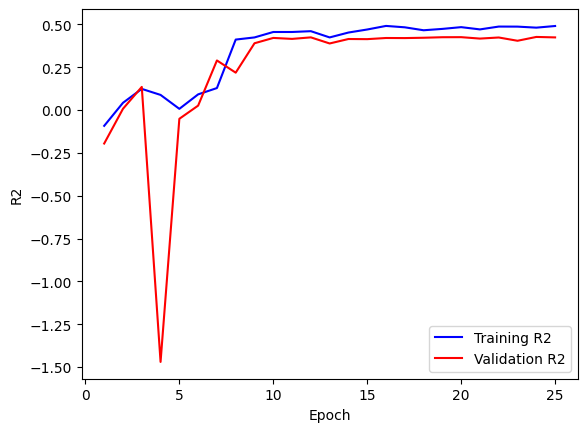

In [17]:
# The convergence plot
plt.plot(range(1, len(train_r2_history3)+1), train_r2_history3, color='blue', label='Training R2')
plt.plot(range(1, len(val_r2_history3)+1), val_r2_history3, color='red', label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.show()

RMSE: 0.6368
Pearson Correlation Coefficient: 0.5413
Spearman Correlation Coefficient: 0.6018
R2 score: 0.0741


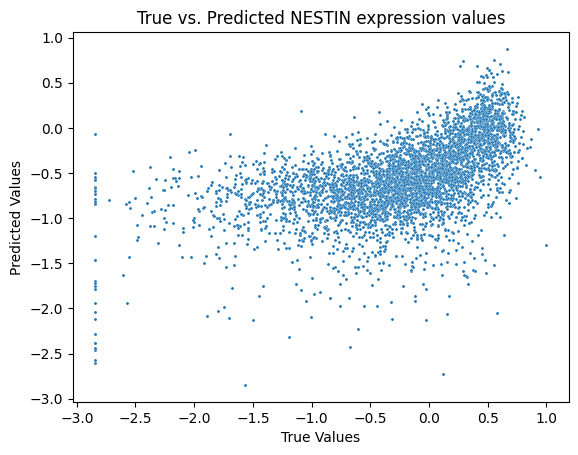

In [18]:
test_model(model3, test_loader)

We also try not to freeze the layers and optimize all the parameters, but still no difference...

In [19]:
model4 = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model4.fc.in_features
model4.fc = nn.Linear(num_ftrs, 1)
model4 = model4.to(device).float()

# Loss and optimizer
criterion4 = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer4 = optim.SGD(model4.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler4 = optim.lr_scheduler.StepLR(optimizer4, step_size=7, gamma=0.1)

In [20]:
model4, train_loss_history4, val_loss_history4, train_r2_history4, val_r2_history4 = \
    train_val(model4, criterion4, optimizer4, scheduler4, train_loader, val_loader, num_epochs, 'model3.pt')

Training epoch 1......
Average training loss: 0.6397151315150483; R2: -0.4276846074040026
Average validation loss: 0.4475718975134006; R2: -0.05919929807547275
Training epoch 2......
Average training loss: 0.2935564168994291; R2: 0.3448552960467218
Average validation loss: 0.22976360633367499; R2: 0.45625395775878963
Training epoch 3......
Average training loss: 0.2559009239103304; R2: 0.4288929652840896
Average validation loss: 0.26375371320086344; R2: 0.37581482601187244
Training epoch 4......
Average training loss: 0.2123881386583333; R2: 0.5260026444827499
Average validation loss: 0.27998293707617244; R2: 0.33740762291404414
Training epoch 5......
Average training loss: 0.16328437243281044; R2: 0.6355900067133863
Average validation loss: 0.31175318132979235; R2: 0.2622218891080377
Training epoch 6......
Average training loss: 0.16443647529177097; R2: 0.6330188002887254
Average validation loss: 0.23269246663148543; R2: 0.4493226729946608
Training epoch 7......
Average training loss:

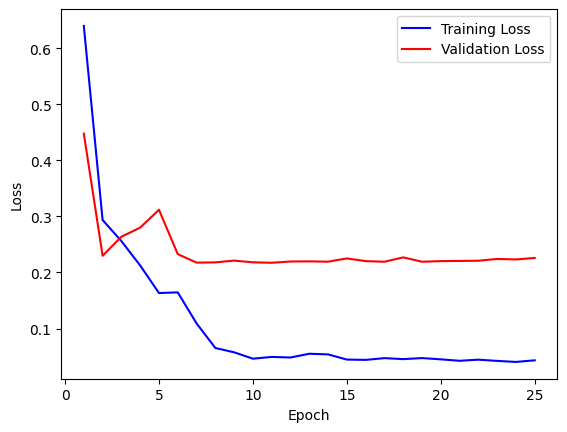

In [21]:
# The convergence plot
plt.plot(range(1, len(train_loss_history4)+1), train_loss_history4, color='blue', label='Training Loss')
plt.plot(range(1, len(val_loss_history4)+1), val_loss_history4, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

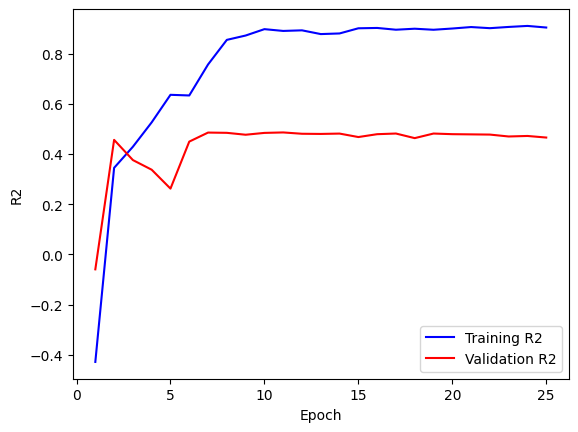

In [22]:
# The convergence plot
plt.plot(range(1, len(train_r2_history4)+1), train_r2_history4, color='blue', label='Training R2')
plt.plot(range(1, len(val_r2_history4)+1), val_r2_history4, color='red', label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.show()

RMSE: 0.6859
Pearson Correlation Coefficient: 0.5185
Spearman Correlation Coefficient: 0.6005
R2 score: -0.0739


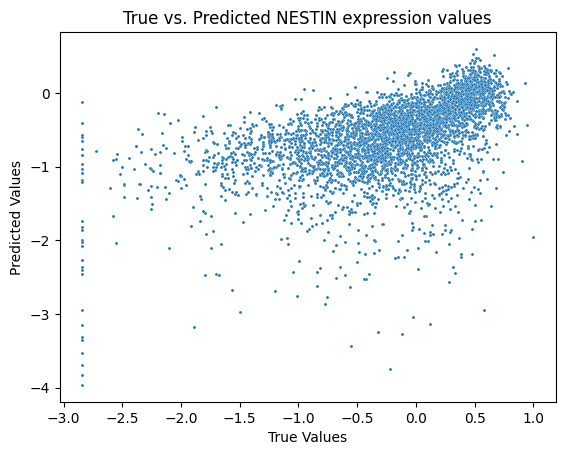

In [23]:
test_model(model4, test_loader)

Below is a summary of performance metrics for various model and feature combinations (we have omitted those with R2 Scores close to or less than 0, for they are close to or worse than predicting the mean). It can be seen that on the test set, the SVR model performs the best with the combined features (HRGB + PCA + GLCM) on all four metrics.

<style>
table th:first-of-type {
    width: 120pt;
}
table th {
    width: 100pt;
}
</style>

| Model | RMSE | Pearson | Spearman | R2 Score |
| :---- | :--: | :-----: | :------: | :------: |
| OLS + PCA | 0.5700 | 0.6464 | 0.7399 | 0.2584 |
| OLS + TL | 0.5943 | 0.4715 | 0.5657 | 0.1937 |
| MLP + HRGB | 0.5906 | 0.6617 | 0.7336 | 0.2036 |
| MLP + PCA | 0.5839 | 0.6466 | 0.7392 | 0.2217 |
| MLP + TL | 0.5865 | 0.4708 | 0.5601 | 0.2147 |
| SVR + HRGB | 0.5449 | 0.6635 | 0.7415 | 0.3222 |
| SVR + PCA | 0.5785 | 0.6344 | 0.7199 | 0.2359 |
| SVR + TL | 0.6080 | 0.4080 | 0.5654 | 0.1561 |
| CNN | 0.5942 | 0.5327 | 0.5783 | 0.1940 |
| ResNet TL | 0.5977 | 0.5529 | 0.6112 | 0.1844 |
| **SVR + combined** | **0.5414** | **0.6661** | **0.7435** | **0.3309** |

Here MLP and SVR are the ones acquired by grid search with a scaler, while "CNN" and "ResNet TL" refers to model1 and model2 above (our simple ConvNet and freezed layers ResNet transfer learning with Adam optimizer).

*(ii) Create a neural network using PyTorch to simultaneously predict the expression levels of five specific proteins (EGFR, PTEN, NESTIN, SOX2, and MET) from given image patches. You have the flexibility to choose the architecture of the neural network and the loss functions you deem appropriate for this task.*

*For model validation, employ a "leave one specimen out cross-validation" strategy. This approach involves sequentially using data from one specimen as the test set and the combined data from the remaining specimens as the training set. This method is similar to a 4-fold cross-validation but specifically tailored to ensure that each specimen is used as a test set exactly once. This validation technique ensures that your model's performance is evaluated on entirely unseen data, mimicking a scenario where the model is tested on data from a new specimen. For a practical understanding of how this is implemented, you can refer to the GroupKFold method in scikit-learn.*

*After training and validating your model, create a total of 20 scatter plots to visually represent your results. These plots should compare the predicted versus actual expression levels for each of the five proteins across the four specimens. This means you'll generate one plot for each protein per specimen.*

*Finally, quantify the performance of your optimal model for each protein with the following statistical metrics:*

- *RMSE (Root Mean Square Error): Measures the model's prediction error.*
- *Pearson Correlation Coefficient: Assesses the linear relationship between predicted and actual values.*
- *Spearman Correlation Coefficient: Evaluates the monotonic relationship between predicted and actual values.*
- *R2 Score: Indicates the proportion of variance in the dependent variable predictable from the independent variable(s).*

*For each metric, report both the average and standard deviation across the specimens for every target protein. This comprehensive evaluation will help in understanding the model's predictive accuracy, reliability, and the nature of its errors or biases.*

***HINT:** A naïve (but possibly effective) strategy can be to simply try the same network architecture in 3(a) and train different models separately for each target variable.*

In [12]:
def my_pipeline(protein, specimen):
    print(f"Predicting protein {protein} using {specimen} for validation......")
    model_name = 'model_' + protein + '_' + specimen + '.pt'
    df_train = df[df['specimen_id'] != specimen]
    df_val = df[df['specimen_id'] == specimen]
    mean, std = calculate_mean_and_std(image_folder, df_train)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset = CustomDataset(image_folder=image_folder,
                                dataframe=df_train,
                                column='NESTIN',
                                transform=transform)

    val_dataset = CustomDataset(image_folder=image_folder,
                                dataframe=df_val,
                                column='NESTIN',
                                transform=transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    model = ConvNet().to(device).float()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_loss_history, val_loss_history, train_r2_history, val_r2_history = \
        train_val(model, criterion, optimizer, None, train_loader, val_loader, 20, model_name)
    
    model.eval()

    predictions = []
    true_levels = []

    with torch.no_grad():
        for images, levels in val_loader:
            images = images.float().to(device)
            levels = levels.to(device)
            outputs = model(images)

            predictions.extend(outputs.cpu().numpy())
            true_levels.extend(levels.cpu().numpy())

    predictions = np.array(predictions).reshape(-1)
    true_levels = np.array(true_levels)

    rmse = mean_squared_error(true_levels, predictions, squared=False)
    pearson_corr, _ = pearsonr(true_levels, predictions)
    spearman_corr, _ = spearmanr(true_levels, predictions)
    r2 = r2_score(true_levels, predictions)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    axs[0].plot(range(1, len(train_loss_history)+1), train_loss_history, color='blue', label='Training Loss')
    axs[0].plot(range(1, len(val_loss_history)+1), val_loss_history, color='red', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(range(1, len(train_r2_history)+1), train_r2_history, color='blue', label='Training R2')
    axs[1].plot(range(1, len(val_r2_history)+1), val_r2_history, color='red', label='Validation R2')
    axs[1].set_title('Training and Validation R2')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('R2')
    axs[1].legend()

    sns.scatterplot(x=true_levels, y=predictions, s=5, ax=axs[2])
    axs[2].set_title('True vs. Predicted Values')
    axs[2].set_xlabel('True Values')
    axs[2].set_ylabel('Predicted Values')

    plt.tight_layout()
    plt.show()

    print('RMSE: {:.4f},'.format(rmse), 'Pearson: {:.4f},'.format(pearson_corr), \
        'Spearman: {:.4f},'.format(spearman_corr), 'R2 score: {:.4f}'.format(r2))

Predicting protein EGFR using A1 for validation......


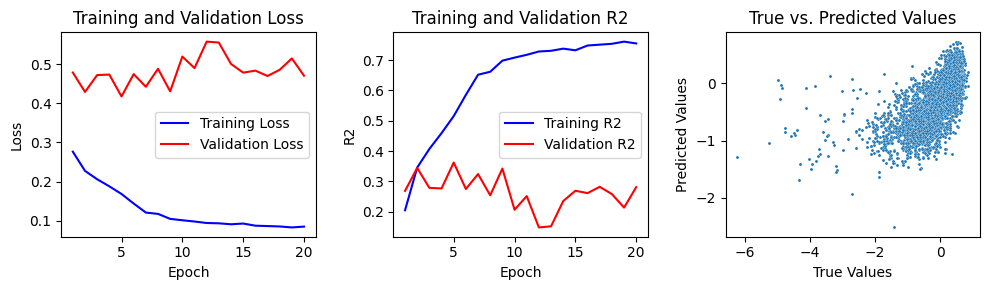

RMSE: 0.6461, Pearson: 0.6194, Spearman: 0.7251, R2 score: 0.3622
Predicting protein EGFR using B1 for validation......


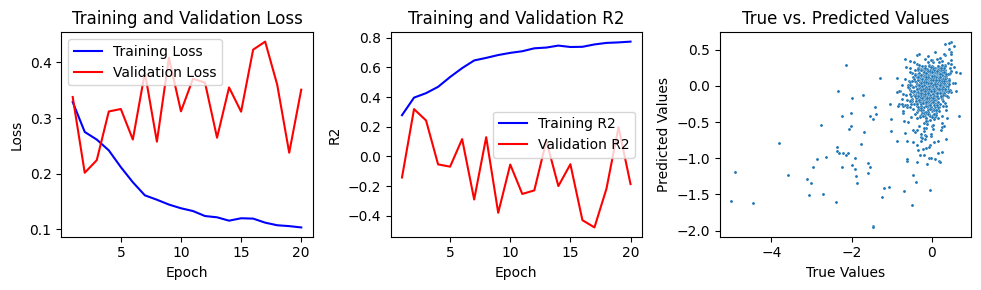

RMSE: 0.4490, Pearson: 0.5778, Spearman: 0.3207, R2 score: 0.3187
Predicting protein EGFR using C1 for validation......


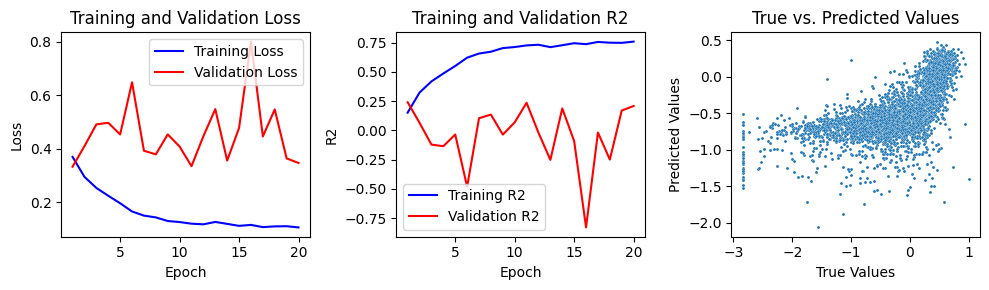

RMSE: 0.5768, Pearson: 0.6242, Spearman: 0.6888, R2 score: 0.2405
Predicting protein EGFR using D1 for validation......


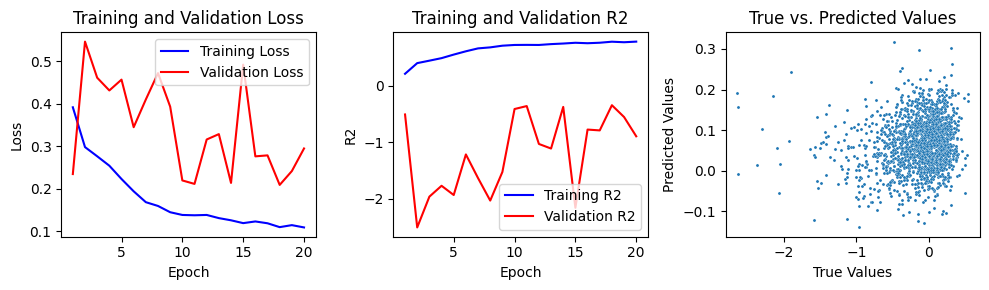

RMSE: 0.4339, Pearson: 0.1454, Spearman: 0.1424, R2 score: -0.2098
Predicting protein PTEN using A1 for validation......


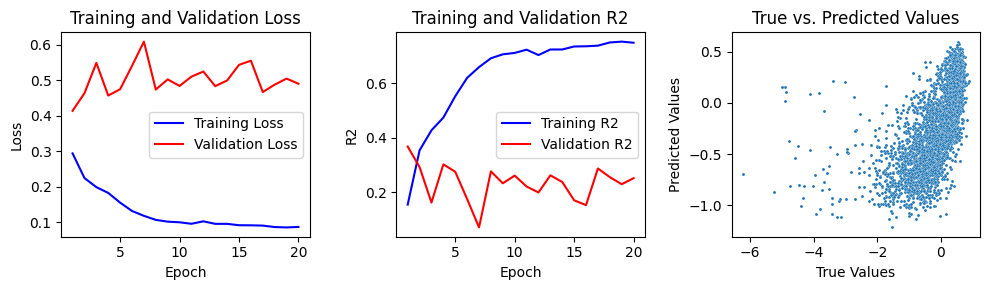

RMSE: 0.6435, Pearson: 0.6167, Spearman: 0.7435, R2 score: 0.3673
Predicting protein PTEN using B1 for validation......


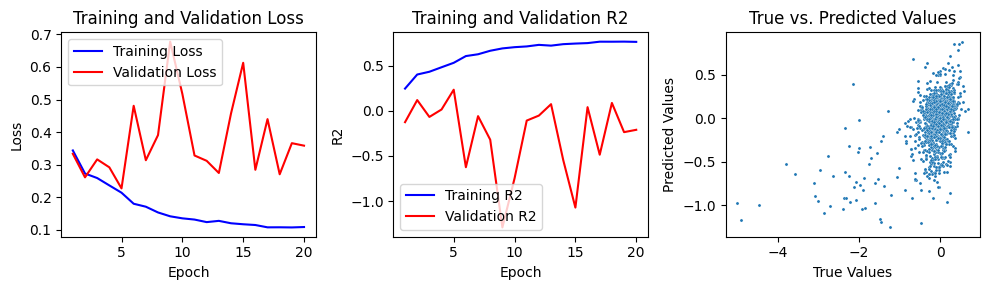

RMSE: 0.4765, Pearson: 0.5112, Spearman: 0.3634, R2 score: 0.2329
Predicting protein PTEN using C1 for validation......


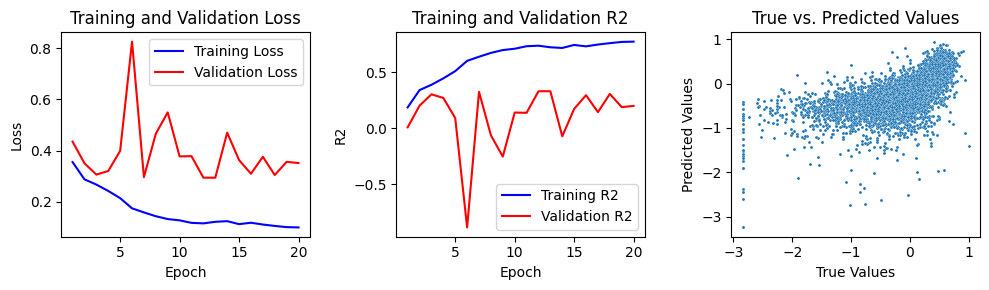

RMSE: 0.5418, Pearson: 0.5841, Spearman: 0.6455, R2 score: 0.3298
Predicting protein PTEN using D1 for validation......


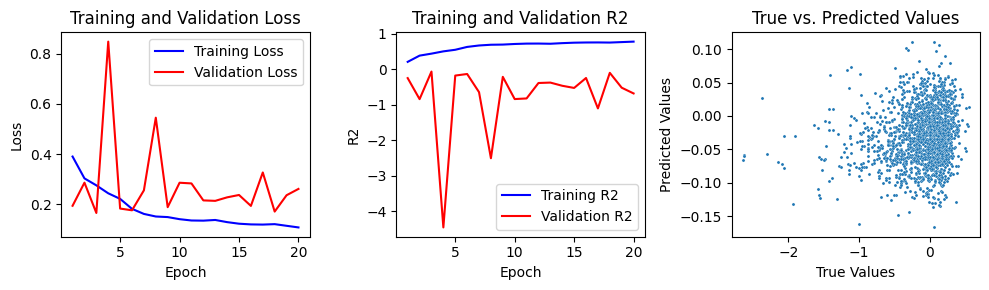

RMSE: 0.4016, Pearson: 0.1443, Spearman: 0.1440, R2 score: -0.0363
Predicting protein NESTIN using A1 for validation......


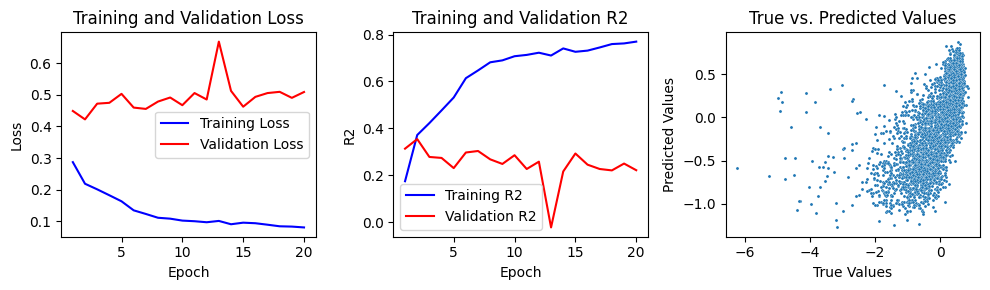

RMSE: 0.6500, Pearson: 0.6071, Spearman: 0.7350, R2 score: 0.3543
Predicting protein NESTIN using B1 for validation......


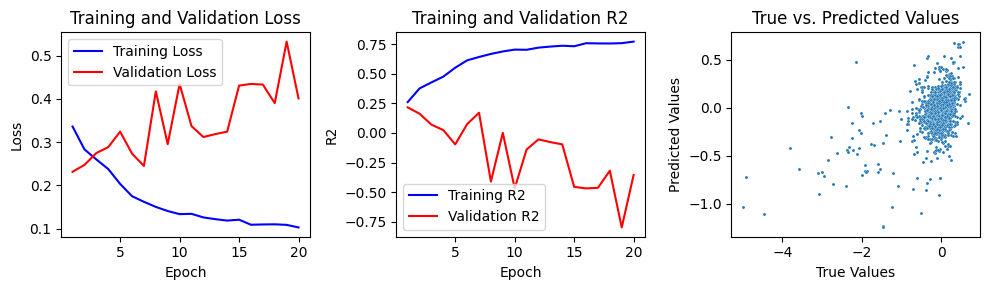

RMSE: 0.4814, Pearson: 0.5094, Spearman: 0.3713, R2 score: 0.2170
Predicting protein NESTIN using C1 for validation......


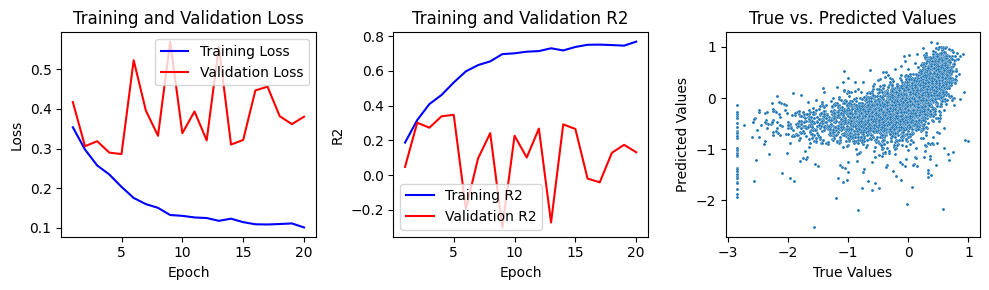

RMSE: 0.5348, Pearson: 0.6076, Spearman: 0.6740, R2 score: 0.3471
Predicting protein NESTIN using D1 for validation......


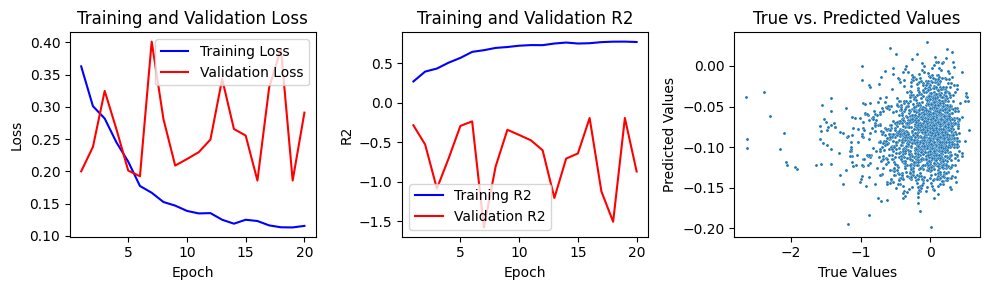

RMSE: 0.3941, Pearson: 0.1201, Spearman: 0.1197, R2 score: 0.0023
Predicting protein SOX2 using A1 for validation......


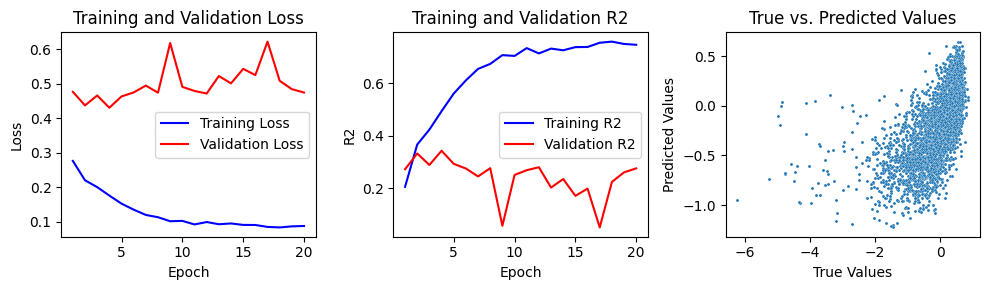

RMSE: 0.6560, Pearson: 0.6011, Spearman: 0.7223, R2 score: 0.3424
Predicting protein SOX2 using B1 for validation......


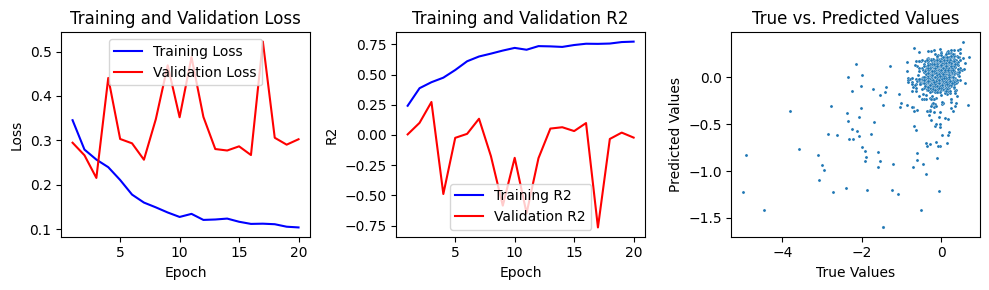

RMSE: 0.4639, Pearson: 0.5880, Spearman: 0.3033, R2 score: 0.2729
Predicting protein SOX2 using C1 for validation......


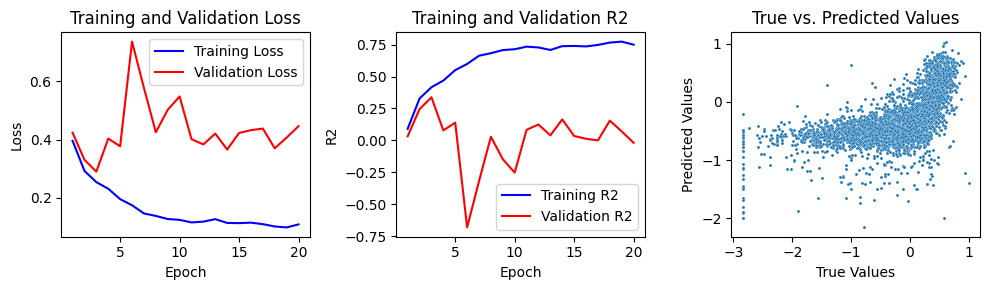

RMSE: 0.5387, Pearson: 0.5927, Spearman: 0.6411, R2 score: 0.3374
Predicting protein SOX2 using D1 for validation......


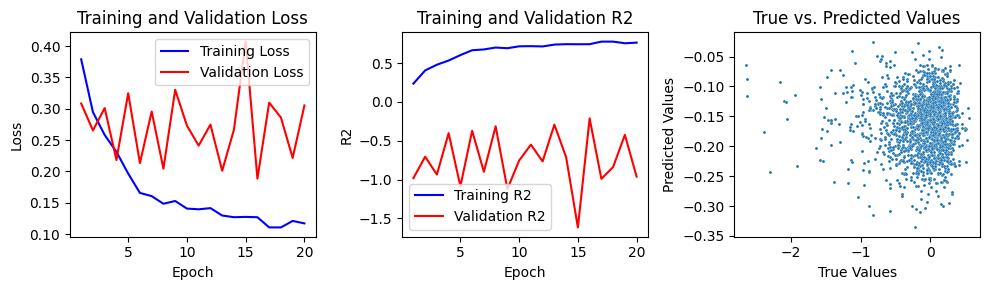

RMSE: 0.4011, Pearson: -0.0414, Spearman: -0.0177, R2 score: -0.0338
Predicting protein MET using A1 for validation......


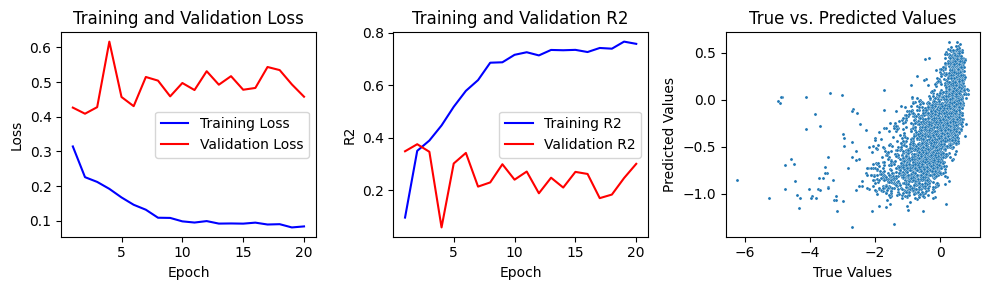

RMSE: 0.6394, Pearson: 0.6325, Spearman: 0.7550, R2 score: 0.3753
Predicting protein MET using B1 for validation......


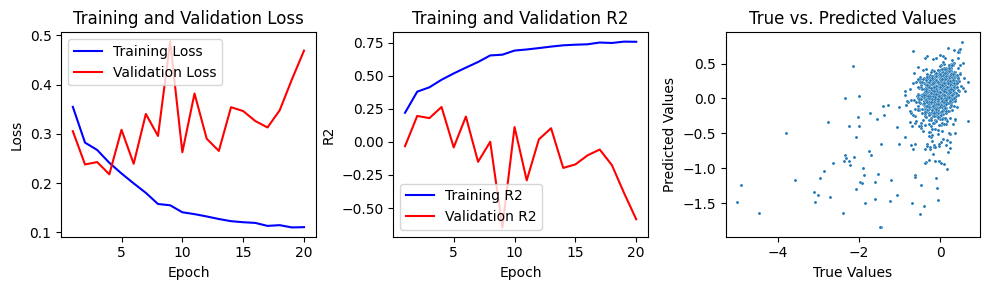

RMSE: 0.4667, Pearson: 0.5874, Spearman: 0.3746, R2 score: 0.2640
Predicting protein MET using C1 for validation......


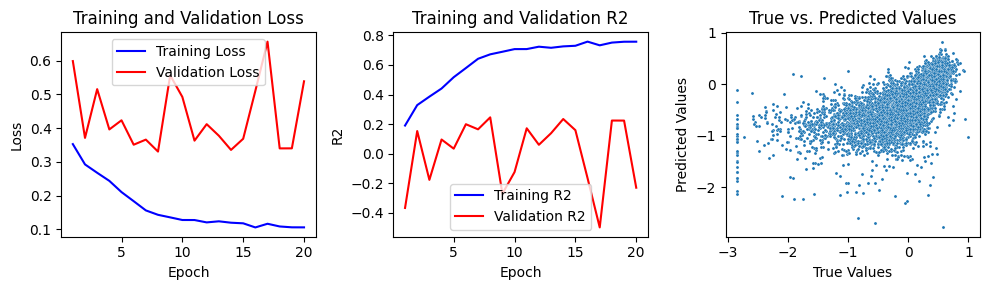

RMSE: 0.5748, Pearson: 0.5973, Spearman: 0.6714, R2 score: 0.2457
Predicting protein MET using D1 for validation......


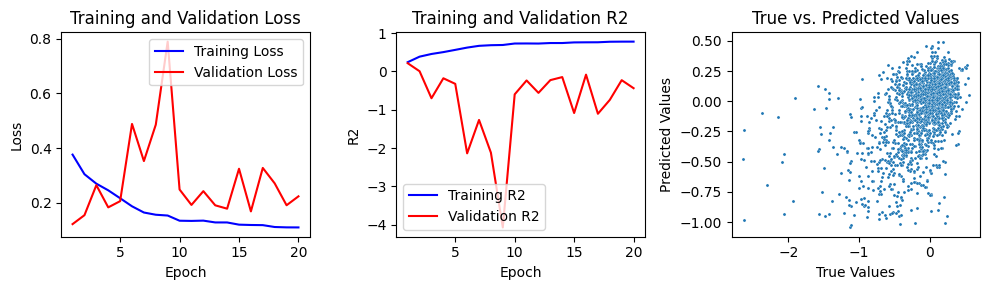

RMSE: 0.3495, Pearson: 0.5217, Spearman: 0.4924, R2 score: 0.2150


In [13]:
for protein in ['EGFR', 'PTEN', 'NESTIN', 'SOX2', 'MET']:
    for specimen in ['A1', 'B1', 'C1', 'D1']:
        my_pipeline(protein, specimen)

From the shape of the scatter plot, it can be observed that the validation performance on specimen A1 is the best for all types of proteins, followed by B1. The shapes of these two specimens are relatively regular, with most points roughly clustered near the ideally perfect line passing through the origin with a slope of 1 (although there are some margins).

The validation performance on D1 is most often the worst, and the scatter plot for the first four proteins appears to be almost randomly distributed without any discernible pattern (although for protein MET, it seems to fit quite well).

C1 performs relatively well in the top right corner of the plot (usually when both predicted and true values are between 0 and 1), but there is a tedious tail in the bottom left portion where true values are less than 0, which indicates the prediction results there become more unsatisfactory. (Especially when the true values are close to -3, the model predicts everything from -2 to 0!)

We then look at the average and standard deviation of each metric (Root Mean Square Error, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 Score) across the specimens for every target protein. Tables are created to better visualize and compare these metrics, with one table for each protein. Rows represent the specimens used for validation, and columns represent the metrics. The best value for each metric on that protein is annotated with italic and underline.

Predicting Protein ***EGFR***

<style>
table th:first-of-type {
    width: 120pt;
}
table th {
    width: 100pt;
}
</style>

| Val Specimen | RMSE | Pearson | Spearman | R2 Score |
| :----------- | :--: | :-----: | :------: | :------: |
| *A1* | 0.6461 | 0.6194 | <u>*0.7251*</u> | <u>*0.3622*</u> |
| *B1* | 0.4490 | 0.5778 | 0.3207 | 0.3187 |
| *C1* | 0.5768 | <u>*0.6242*</u> | 0.6888 | 0.2405 |
| *D1* | <u>*0.4339*</u> | 0.1454 | 0.1424 | -0.2098 |
| ***Average*** | ***0.5265*** | ***0.4917*** | ***0.4693*** | ***0.1779*** |
| ***Standard Deviation*** | ***0.1023*** | ***0.2318*** | ***0.2843*** | ***0.2633*** |

Predicting Protein ***PTEN***

<style>
table th:first-of-type {
    width: 120pt;
}
table th {
    width: 100pt;
}
</style>

| Val Specimen | RMSE | Pearson | Spearman | R2 Score |
| :----------- | :--: | :-----: | :------: | :------: |
| *A1* | 0.6435 | <u>*0.6167*</u> | <u>*0.7435*</u> | <u>*0.3673*</u> |
| *B1* | 0.4765 | 0.5112 | 0.3634 | 0.2329 |
| *C1* | 0.5418 | 0.5841 | 0.6455 | 0.3298 |
| *D1* | <u>*0.4016*</u> | 0.1443 | 0.1440 | -0.0363 |
| ***Average*** | ***0.5159*** | ***0.4641*** | ***0.4741*** | ***0.2234*** |
| ***Standard Deviation*** | ***0.1026*** | ***0.2177*** | ***0.2727*** | ***0.1822*** |

Predicting Protein ***NESTIN***

<style>
table th:first-of-type {
    width: 120pt;
}
table th {
    width: 100pt;
}
</style>

| Val Specimen | RMSE | Pearson | Spearman | R2 Score |
| :----------- | :--: | :-----: | :------: | :------: |
| *A1* | 0.6500 | 0.6071 | <u>*0.7350*</u> | <u>*0.3543*</u> |
| *B1* | 0.4814 | 0.5094 | 0.3713 | 0.2170 |
| *C1* | 0.5348 | <u>*0.6076*</u> | 0.6740 | 0.3471 |
| *D1* | <u>*0.3941*</u> | 0.1201 | 0.1197 | 0.0023 |
| ***Average*** | ***0.5151*** | ***0.4611*** | ***0.4750*** | ***0.2302*** |
| ***Standard Deviation*** | ***0.1070*** | ***0.2319*** | ***0.2853*** | ***0.1645*** |

Predicting Protein ***SOX2***

<style>
table th:first-of-type {
    width: 120pt;
}
table th {
    width: 100pt;
}
</style>

| Val Specimen | RMSE | Pearson | Spearman | R2 Score |
| :----------- | :--: | :-----: | :------: | :------: |
| *A1* | 0.6560 | <u>*0.6011*</u> | <u>*0.7223*</u> | <u>*0.3424*</u> |
| *B1* | 0.4639 | 0.5880 | 0.3033 | 0.2729 |
| *C1* | 0.5387 | 0.5927 | 0.6411 | 0.3374 |
| *D1* | <u>*0.4011*</u> | -0.0414 | -0.0177 | -0.0338 |
| ***Average*** | ***0.5149*** | ***0.4351*** | ***0.4123*** | ***0.2297*** |
| ***Standard Deviation*** | ***0.1096*** | ***0.3177*** | ***0.3392*** | ***0.1785*** |

Predicting Protein ***MET***

<style>
table th:first-of-type {
    width: 120pt;
}
table th {
    width: 100pt;
}
</style>

| Val Specimen | RMSE | Pearson | Spearman | R2 Score |
| :----------- | :--: | :-----: | :------: | :------: |
| *A1* | 0.6394 | <u>*0.6325*</u> | <u>*0.7550*</u> | <u>*0.3753*</u> |
| *B1* | 0.4667 | 0.5874 | 0.3746 | 0.2640 |
| *C1* | 0.5748 | 0.5973 | 0.6714 | 0.2457 |
| *D1* | <u>*0.3495*</u> | 0.5217 | 0.4924 | 0.2150 |
| ***Average*** | ***0.5076*** | ***0.5847*** | ***0.5734*** | ***0.2750*** |
| ***Standard Deviation*** | ***0.1272*** | ***0.0463*** | ***0.1719*** | ***0.0699*** |

It can be observed that the smallest RMSE for each protein is always on D1, however, D1's Pearson, Spearman, and R2 Score are often the worst among the four cross-validations. The remaining three metrics usually perform best on A1, with B1 and C1 falling somewhere in between. Considering the conclusions drawn from the scatter plot observations (A1 has the best validation performance while D1 is the worst), it can be seen that RMSE is not a very effective observation metric (in fact, it is the least effective), as its magnitude is relative and influenced by the distribution of true values themselves. Although the model's predictive performance on D1 is poor, the protein expression levels on D1 have little variation (mostly concentrated between -1 and 0), so a small RMSE does not indicate effectiveness. In contrast, Pearson, Spearman correlation, and R2 Score more accurately reflect the model's performance, especially R2 Score. The R2 Score for D1 on the first four proteins is less than 0, indicating mercilessly that the model's predictive ability is no different from random guessing (worse than predicting the average).

As for these five proteins, cross-validation on all specimens proves that the prediction of protein expression levels from images is most stable and reliable for MET, as its metrics (particularly R2 Score) show the largest mean and smallest variance, while EGFR has a smaller mean and larger variance, indicating the worst prediction performance and least reliability.

(iii) Discuss limitations and possible extensions of the optimal pipeline, e.g., is there any additional information we can utilize to improve prediction performance and how that can be used?  You will be graded on the feasibility and practicality of your ideas and you can get bonus marks depending upon whether you show any preliminary or pilot results.

Consider utilizing the spatial location coordinates (Location_Center_Y, Location_Center_X) for each spot to improve prediction performance of the previous optimal pipeline (SVR with MinMaxScaler). The performance has been slightly improved:

<style>
table th:first-of-type {
    width: 120pt;
}
table th {
    width: 100pt;
}
</style>

| Model | RMSE | Pearson | Spearman | R2 Score |
| :---- | :--: | :-----: | :------: | :------: |
| SVR + combined | 0.5414 | 0.6661 | 0.7435 | 0.3309 |
| **SVR + more** | **0.5349** | **0.6664** | **0.7451** | **0.3469** |

In [20]:
df_more_features_train = pd.concat([
    df_hrgb.loc[df_train.index],
    df_pca.loc[df_train.index][pca_columns],
    df_glcm.loc[df_train.index][glcm_columns],
    df_train[['Location_Center_Y', 'Location_Center_X', 'NESTIN']]
], axis=1)

df_more_features_train.columns = df_more_features_train.columns.astype(str)

df_more_features_test = pd.concat([
    df_hrgb.loc[df_test.index],
    df_pca.loc[df_test.index][pca_columns],
    df_glcm.loc[df_test.index][glcm_columns],
    df_test[['Location_Center_Y', 'Location_Center_X', 'NESTIN']]
], axis=1)

df_more_features_test.columns = df_more_features_test.columns.astype(str)

In [21]:
# Create the SVR regressor and perform grid search
svr_more_search_w_scaler = grid_search_w_scaler(SVR(max_iter=10000), \
    param_grid_svr_w_scaler, df_more_features_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [22]:
relevant_info = sorted_score(svr_more_search_w_scaler)

# Print the sorted information
pd.DataFrame(relevant_info[:10])

regressor__C regressor__gamma regressor__kernel   mean_r2    std_r2  \
0           1.0             auto               rbf  0.119806  0.074079   
1          10.0             auto               rbf  0.061056  0.141632   
2           0.1              NaN              poly  0.043238  0.178321   
3          10.0              NaN            linear  0.028915  0.124420   
4           0.1            scale               rbf  0.015511  0.129655   
5           0.1             auto               rbf -0.001145  0.226123   
6           1.0              NaN            linear -0.090067  0.310570   
7           0.1              NaN            linear -0.122359  0.382380   
8           1.0            scale               rbf -0.140405  0.231590   
9           1.0              NaN              poly -0.167652  0.437435   

   regressor__degree  
0                NaN  
1                NaN  
2                2.0  
3                NaN  
4                NaN  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                2.0

Evaluation metrics for SVR Regression on More Features:
RMSE (Root Mean Square Error): 0.5349
Pearson Correlation Coefficient: 0.6664
Spearman Correlation Coefficient: 0.7451
R2 Score: 0.3469


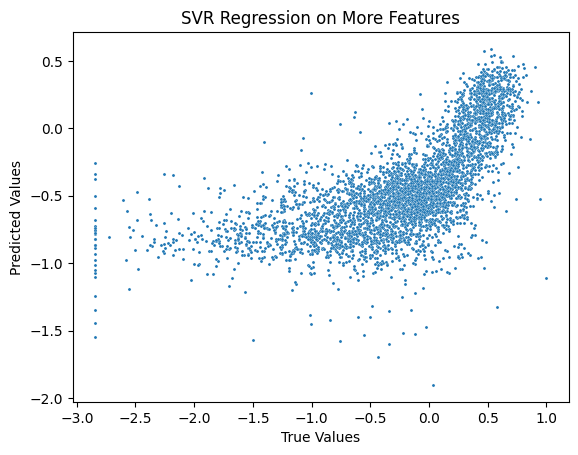

In [23]:
svr_regression(df_more_features_train, df_more_features_test, \
    'More Features', svr_more_search_w_scaler.best_estimator_)